In [1]:
import cogsworth
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
from scipy.integrate import cumulative_trapezoid
from astropy.coordinates import SkyCoord

/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:193: GalaFutureWarning: In a future version of Gala, the current MilkyWayPotential and MilkyWayPotential2022 classes will be combined into a single class, MilkyWayPotential, with an optional 'version' argument to select between the models. To use the old (version 1) MilkyWayPotential, specify version="v1" when creating an instance. To use the newer (version 2 = current MilkyWayPotential2022), specify version="v2".
  warnings.warn(
/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(


In [2]:
%config InlineBackend.figure_format = 'retina'


pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': 0.7*fs,
          'legend.title_fontsize': 0.8*fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Load data

In [3]:
singles = cogsworth.pop.load("/mnt/ceph/users/twagg/underworld/singles", parts=[])
binaries = cogsworth.pop.load("/mnt/ceph/users/twagg/underworld/binaries", parts=[])

/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(
/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(


In [4]:
singles.label = "Singles"
singles.colour = "darkgrey"
binaries.label = "Binaries"
binaries.colour = "#96B73B"

for pop in [singles, binaries]:
    pop.bpp["row_num"] = np.arange(len(pop.bpp))

# Totals

In [5]:
scale_up = 6e10 / binaries.mass_binaries
scale_up

np.float64(3300.668310583825)

Singles
  Total: 196011, NSs: 144171, BHs: 51840
Binaries
  Total: 200499, NSs: 144747, BHs: 55752


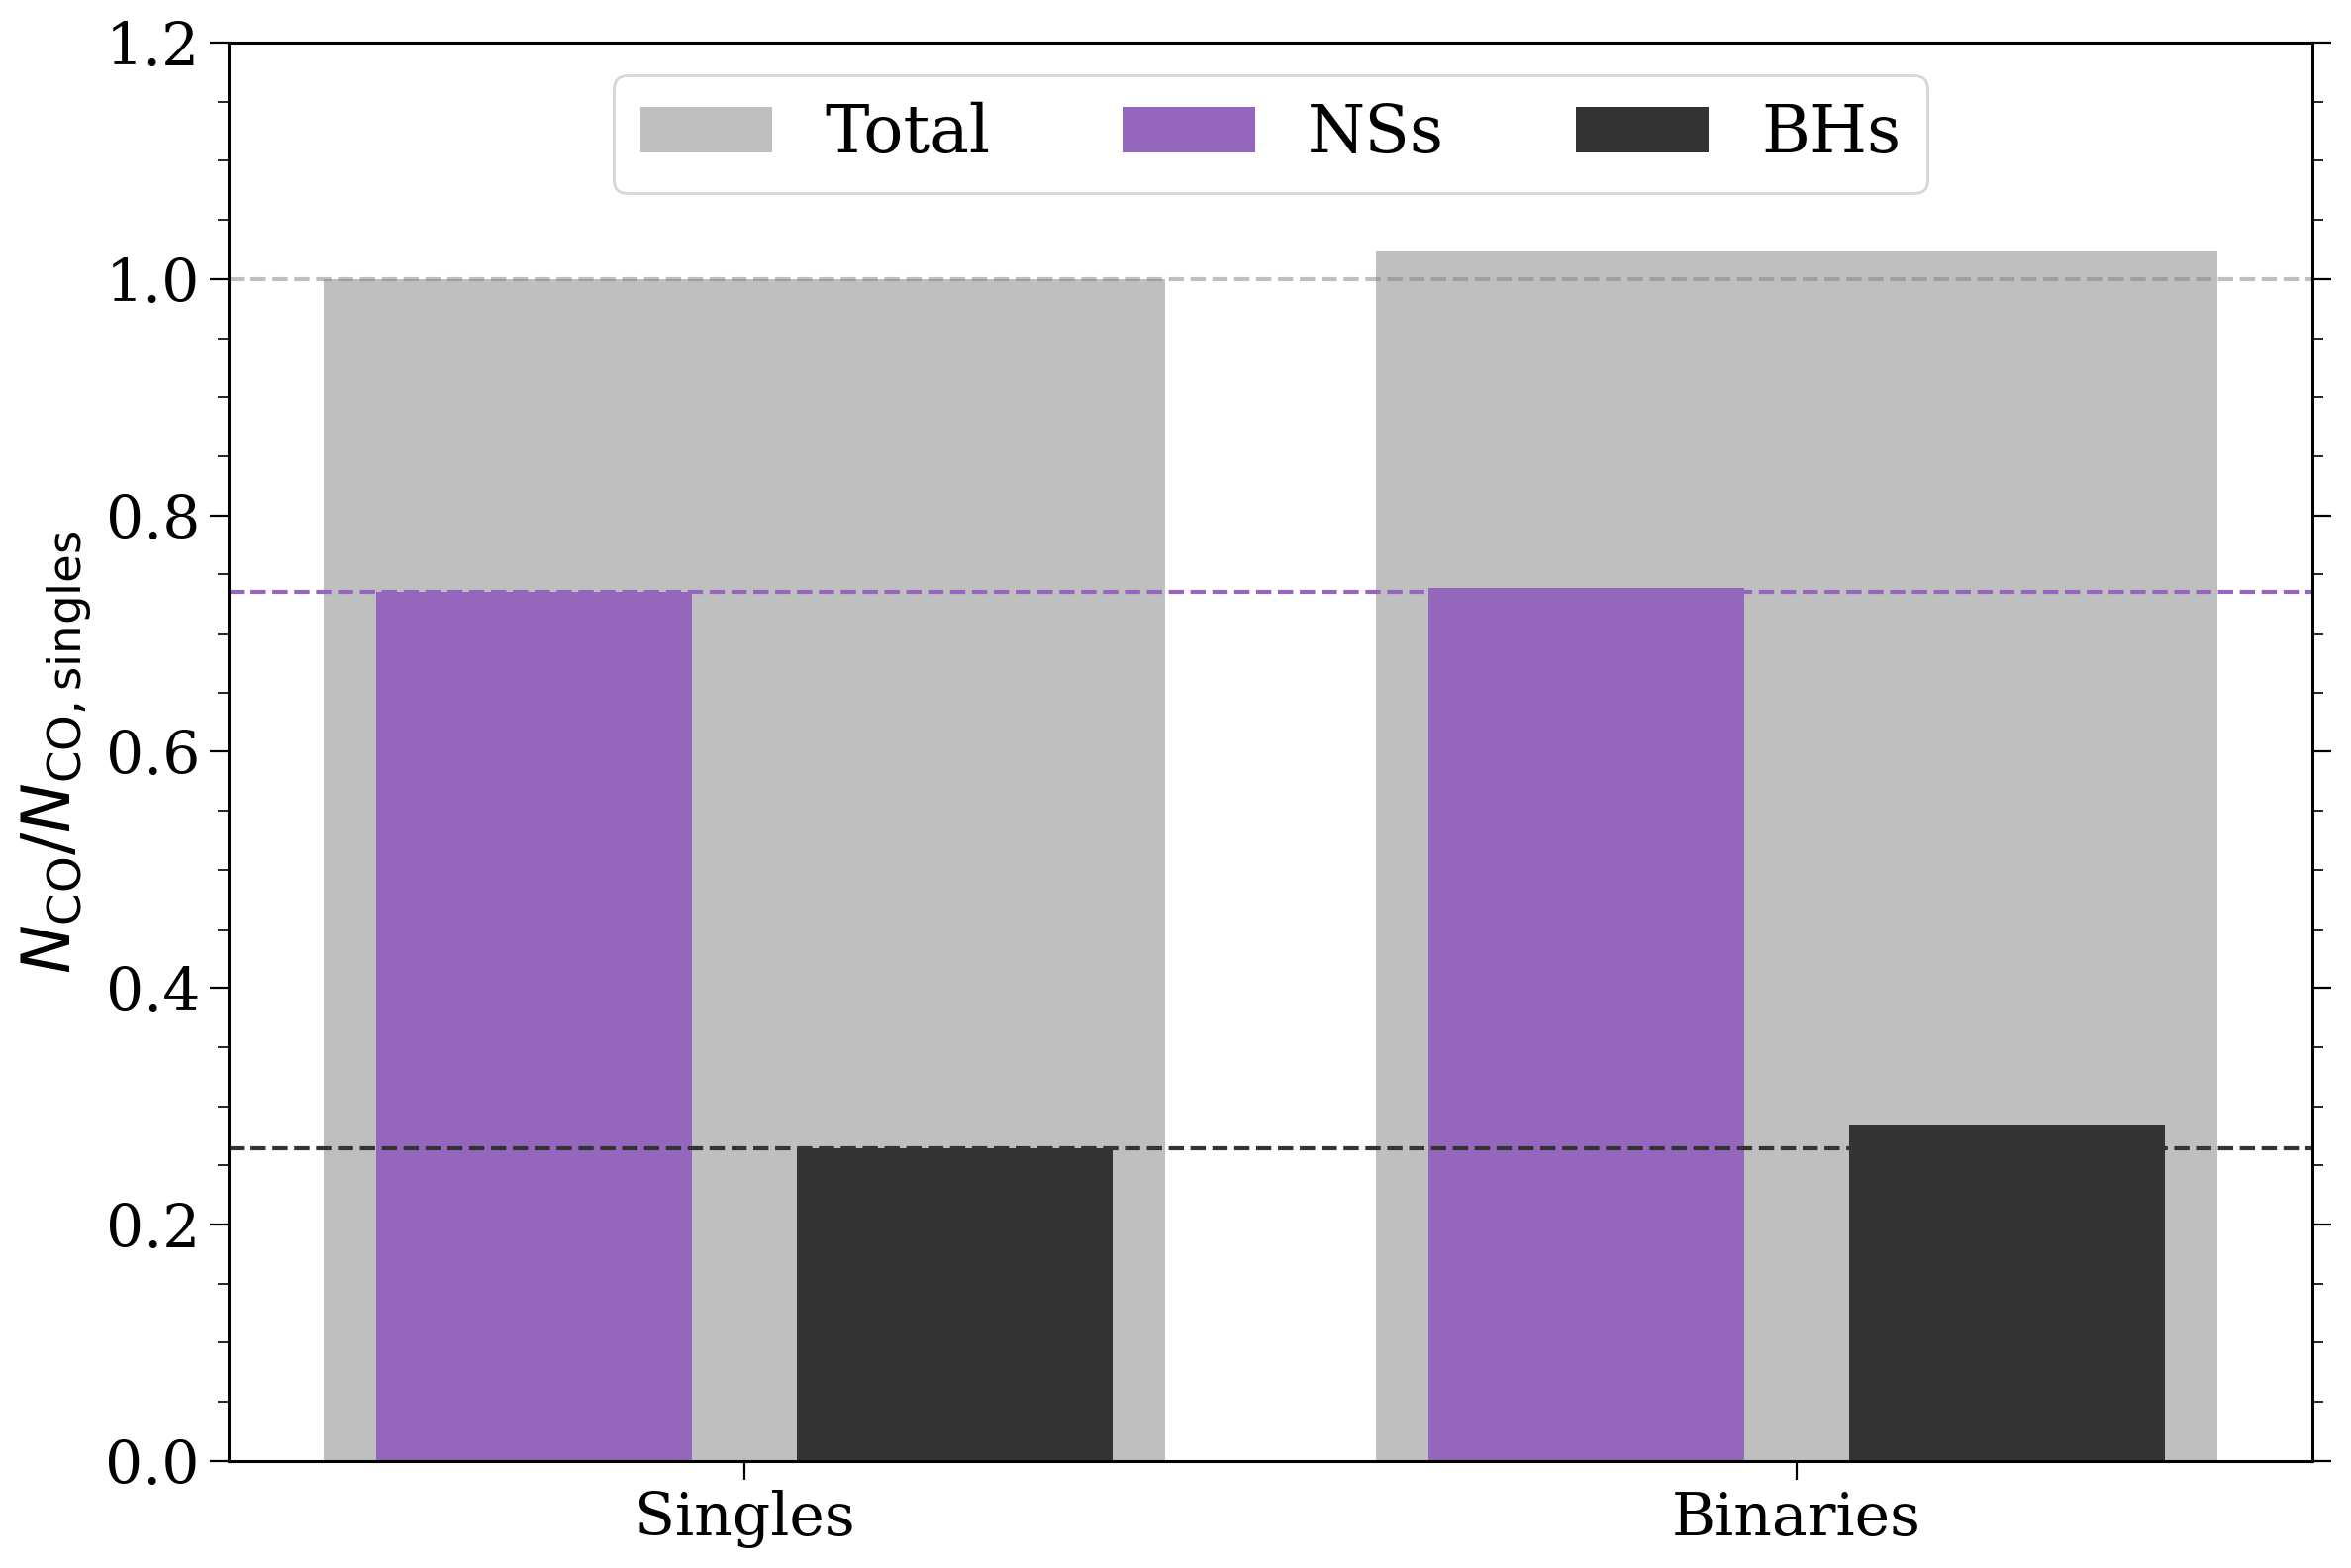

In [6]:
fig, ax = plt.subplots()

total_single_cos = None

for i, pop in enumerate([singles, binaries]):
    n_ns = (pop.final_bpp["kstar_1"] == 13).sum() + (pop.final_bpp["kstar_2"] == 13).sum()
    n_bh = (pop.final_bpp["kstar_1"] == 14).sum() + (pop.final_bpp["kstar_2"] == 14).sum()
    print(f"{pop.label}\n  Total: {n_ns + n_bh}, NSs: {n_ns}, BHs: {n_bh}")

    if total_single_cos is None and pop.label == "Singles":
        total_single_cos = n_ns + n_bh

    ax.bar(i, (n_ns + n_bh) / total_single_cos, label="Total" if i == 0 else None, color="grey", alpha=0.5)
    ax.bar(i - 0.2, n_ns / total_single_cos, width=0.3, label="NSs" if i == 0 else None, color="tab:purple")
    ax.bar(i + 0.2, n_bh / total_single_cos, width=0.3, label="BHs" if i == 0 else None, color="#333")

    if i == 0:
        ax.axhline((n_ns + n_bh) / total_single_cos, color="grey", alpha=0.5, ls='--')
        ax.axhline(n_ns / total_single_cos, color="tab:purple", ls='--')
        ax.axhline(n_bh / total_single_cos, color="#333", ls='--')

ax.set_xticks([0, 1], ["Singles", "Binaries"])
ax.set_ylabel(r"$N_{\rm CO} / N_{\rm CO, singles}$")
ax.legend(ncol=3, loc='upper center', fontsize=fs)

ax.set(
    ylim=(0, 1.2),
)

ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

# show yticks on both sides
ax.yaxis.set_ticks_position('both')

plt.tight_layout()
plt.show()

## Takeaways

Binaries are produce slightly more compact objects?

- Mergers increasing the amount that can reach core-collapse?

Binaries don't have a strong effect on the NSs, but slightly increase the BH total.

- Hypothesis: Stars can now become NSs, some NSs can now become BHs, BHs only go up


## It's mergers right?

Mergers can both increase and decrease the total number of COs formed from a given total stellar mass since:

1. A merger of two stars that could both have become COs decreases your CO count by 1
2. A merger of two low mass stars that couldn't become COs without merging increases your count by 1

Arguably from the IMF, the latter should be more common and so binaries should make many more COs

In [7]:
stellar_merger_nums = binaries.bpp[(
    (
        (binaries.bpp['kstar_1'] == 15) & (binaries.bpp["kstar_2"] < 13)
    ) | (
        (binaries.bpp['kstar_2'] == 15) & (binaries.bpp["kstar_1"] < 13)
    )
)].drop_duplicates(subset="bin_num", keep="first")["bin_num"]

In [8]:
merger_inits = binaries.initC.loc[stellar_merger_nums]

In [9]:
LIM = 7.5
high_mass_mergers = (merger_inits["mass_1"] >= LIM) & (merger_inits["mass_2"] >= LIM)
low_mass_mergers = (merger_inits["mass_1"] < LIM) & (merger_inits["mass_2"] < LIM)

print(f"Total mergers: {len(merger_inits)}")
print(f"  High mass mergers: {high_mass_mergers.sum()} ({high_mass_mergers.sum() / len(merger_inits):.2%})")
print(f"  Low mass mergers: {low_mass_mergers.sum()} ({low_mass_mergers.sum() / len(merger_inits):.2%})")

Total mergers: 137756
  High mass mergers: 41424 (30.07%)
  Low mass mergers: 49470 (35.91%)


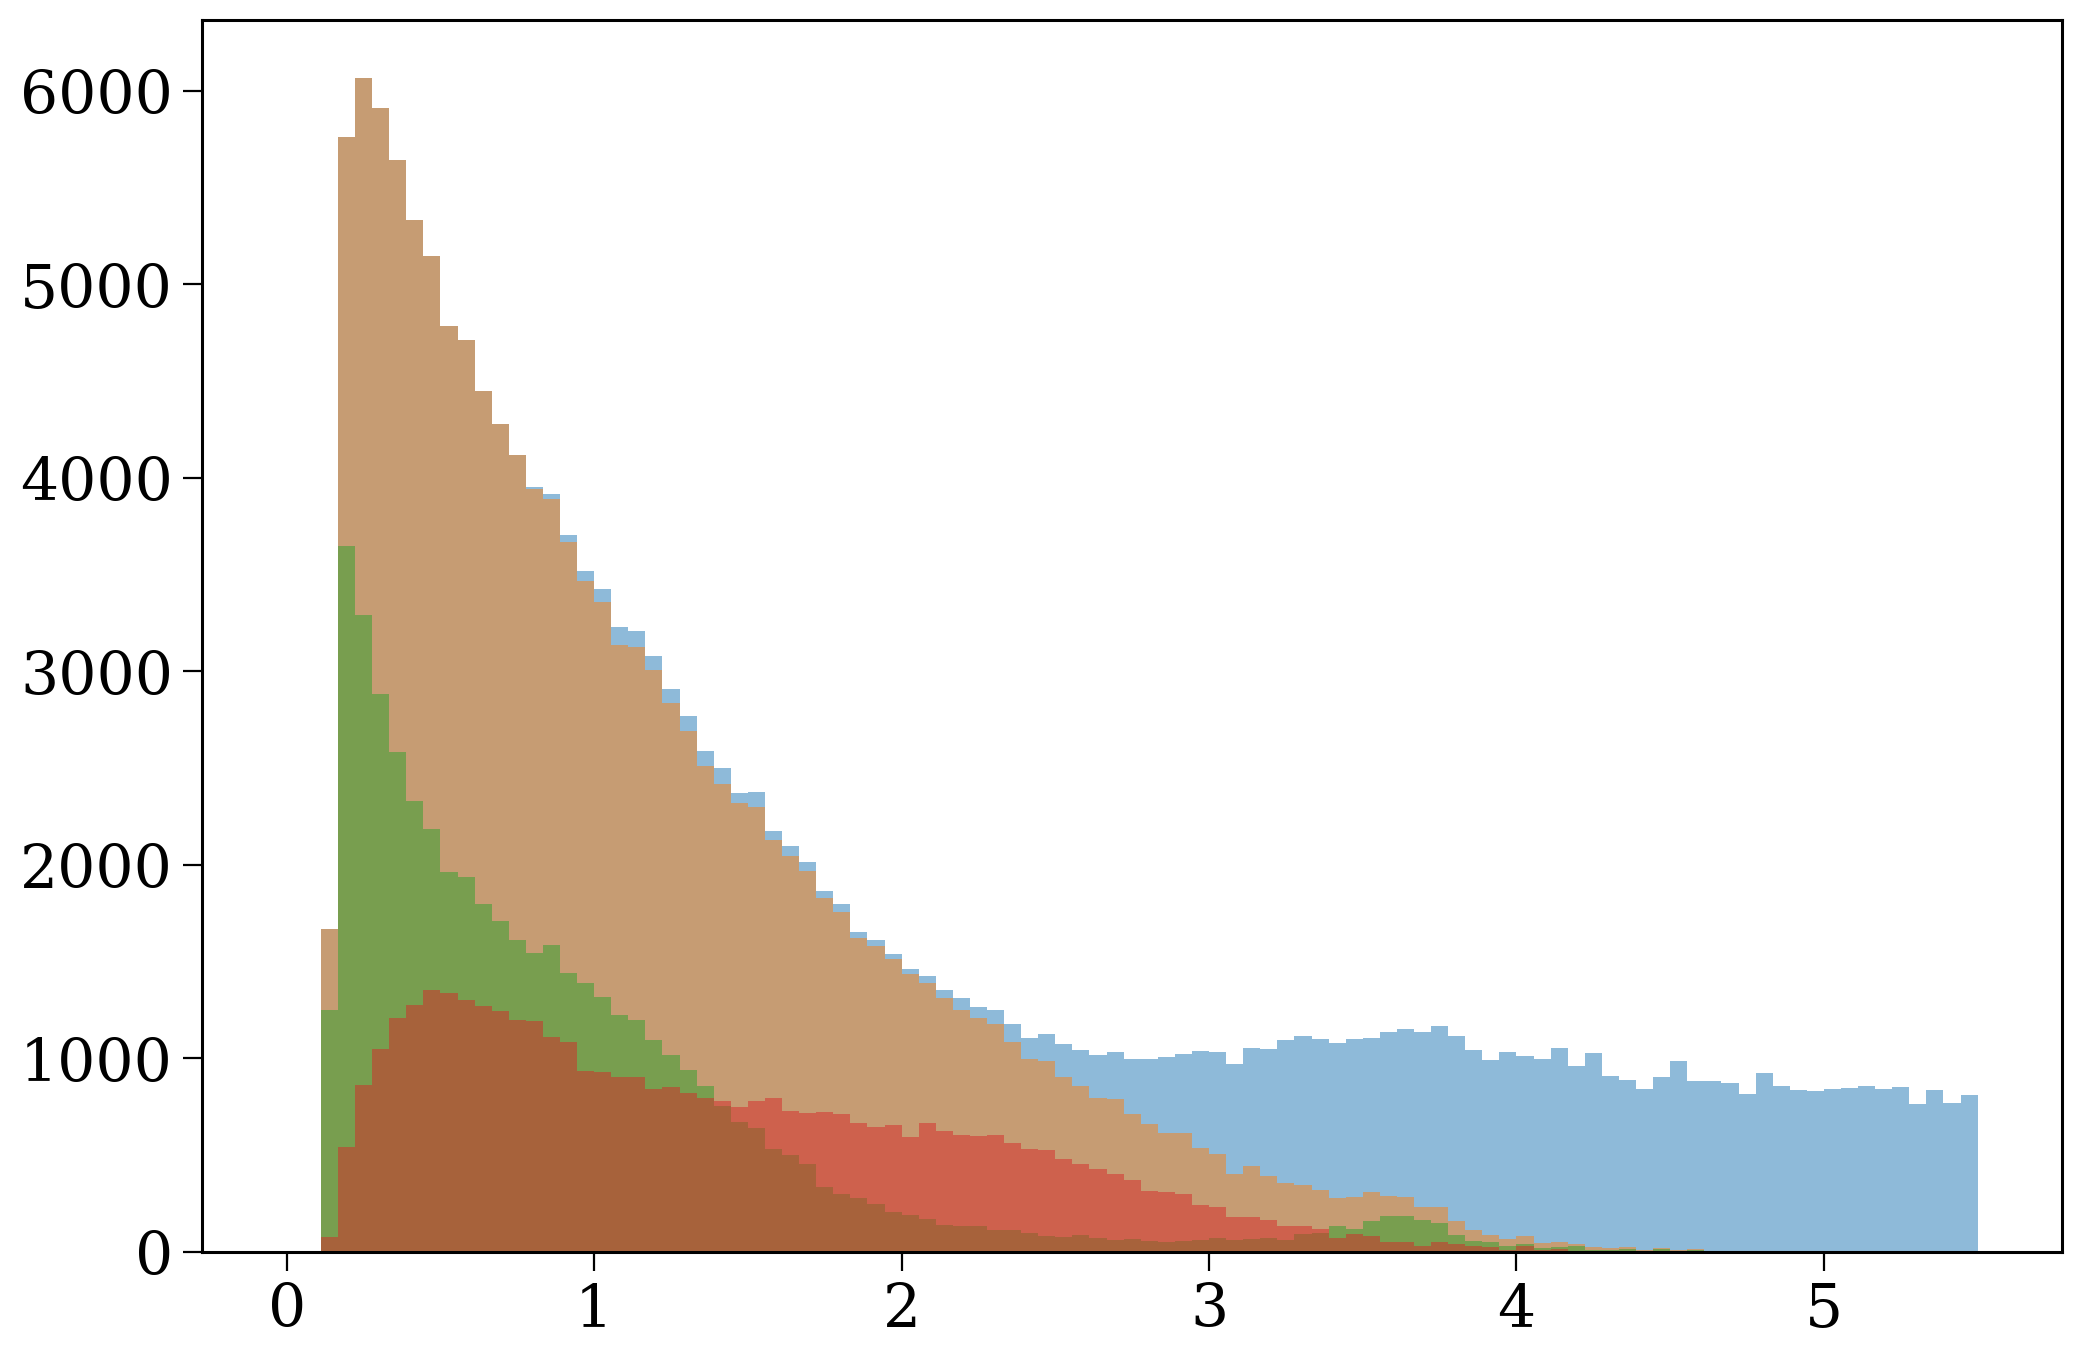

In [10]:
plt.hist(np.log10(binaries.initC["porb"]), bins=np.linspace(0, 5.5, 100), alpha=0.5)
plt.hist(np.log10(merger_inits["porb"]), bins=np.linspace(0, 5.5, 100), alpha=0.5)
plt.hist(np.log10(merger_inits["porb"][low_mass_mergers]), bins=np.linspace(0, 5.5, 100), alpha=0.5)
plt.hist(np.log10(merger_inits["porb"][high_mass_mergers]), bins=np.linspace(0, 5.5, 100), alpha=0.5)
plt.show()

# Mass distributions

504787.0270088443 51840
595004.7856124907 55752


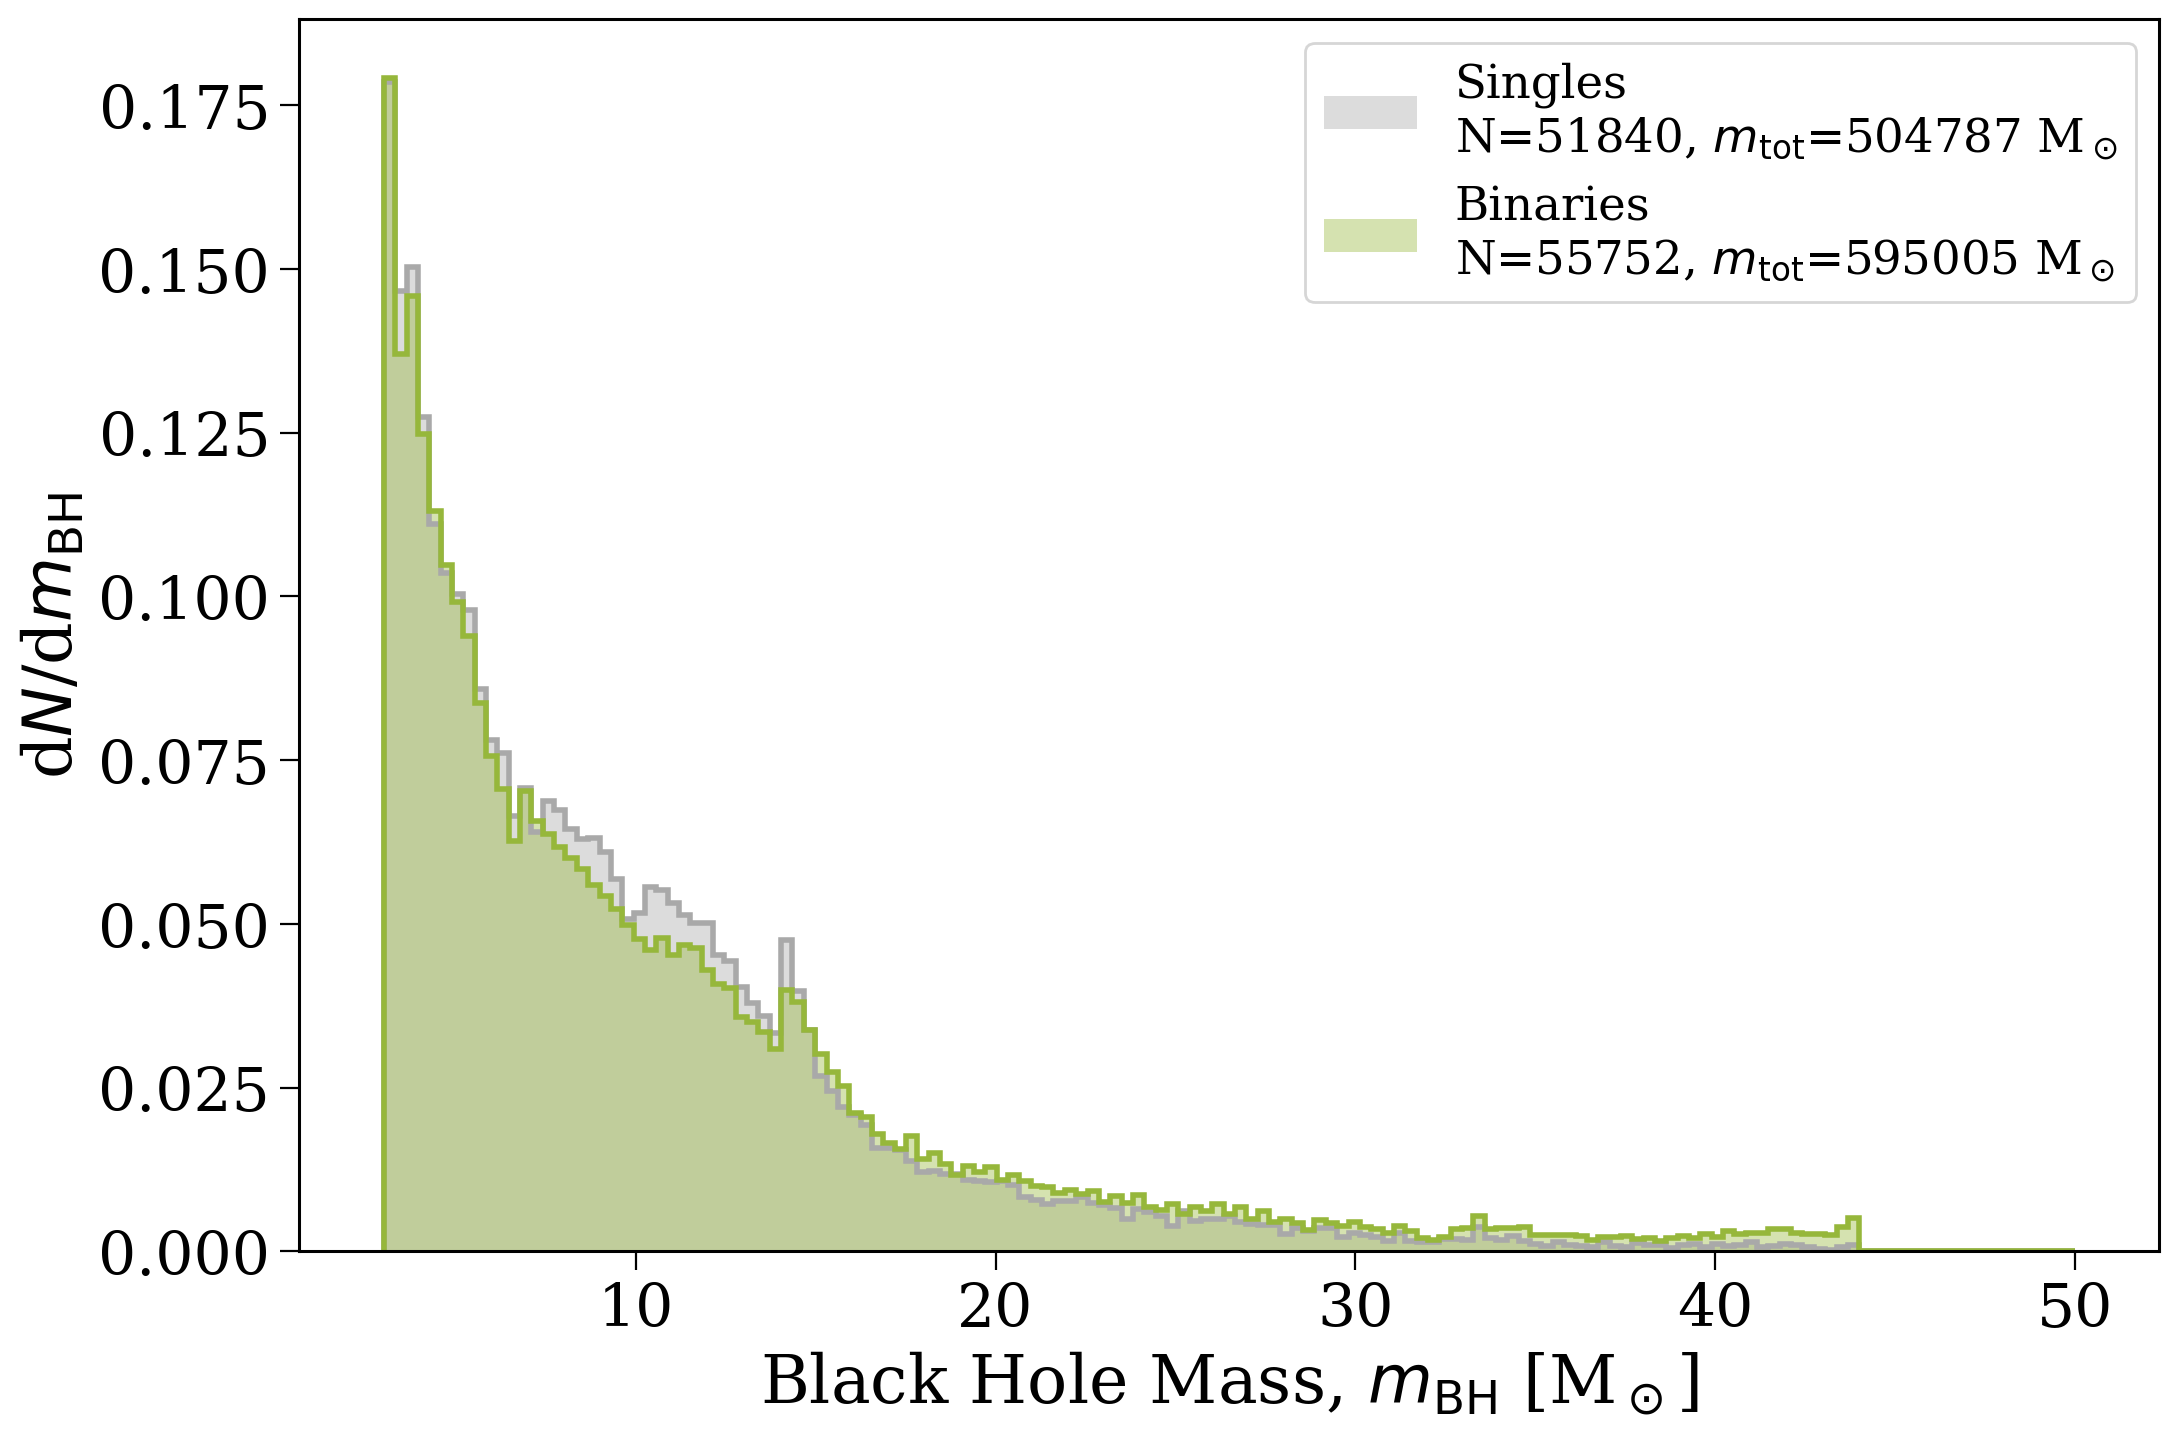

In [11]:
fig, ax = plt.subplots()

bins = np.linspace(3, 50, 150)

for pop in [singles, binaries]:
    bh_masses = np.concatenate(
        (pop.final_bpp["mass_1"][pop.final_bpp["kstar_1"] == 14], 
         pop.final_bpp["mass_2"][pop.final_bpp["kstar_2"] == 14])
    )
    print(sum(bh_masses), len(bh_masses))


    ax.hist(bh_masses, bins=bins, color=pop.colour, lw=2, histtype='step', density=True)
    ax.hist(bh_masses, bins=bins, color=pop.colour, alpha=0.4, density=True, label=f"{pop.label}\nN={len(bh_masses)}, $m_{{\\rm tot}}$={sum(bh_masses):.0f} M$_\odot$")

ax.set(
    xlabel=r"Black Hole Mass, $m_{\rm BH}$ [M$_\odot$]",
    ylabel=r"d$N$/d$m_{\rm BH}$",
)
ax.legend()

plt.show()

214959.1438257314 144171
218390.63931703847 144747


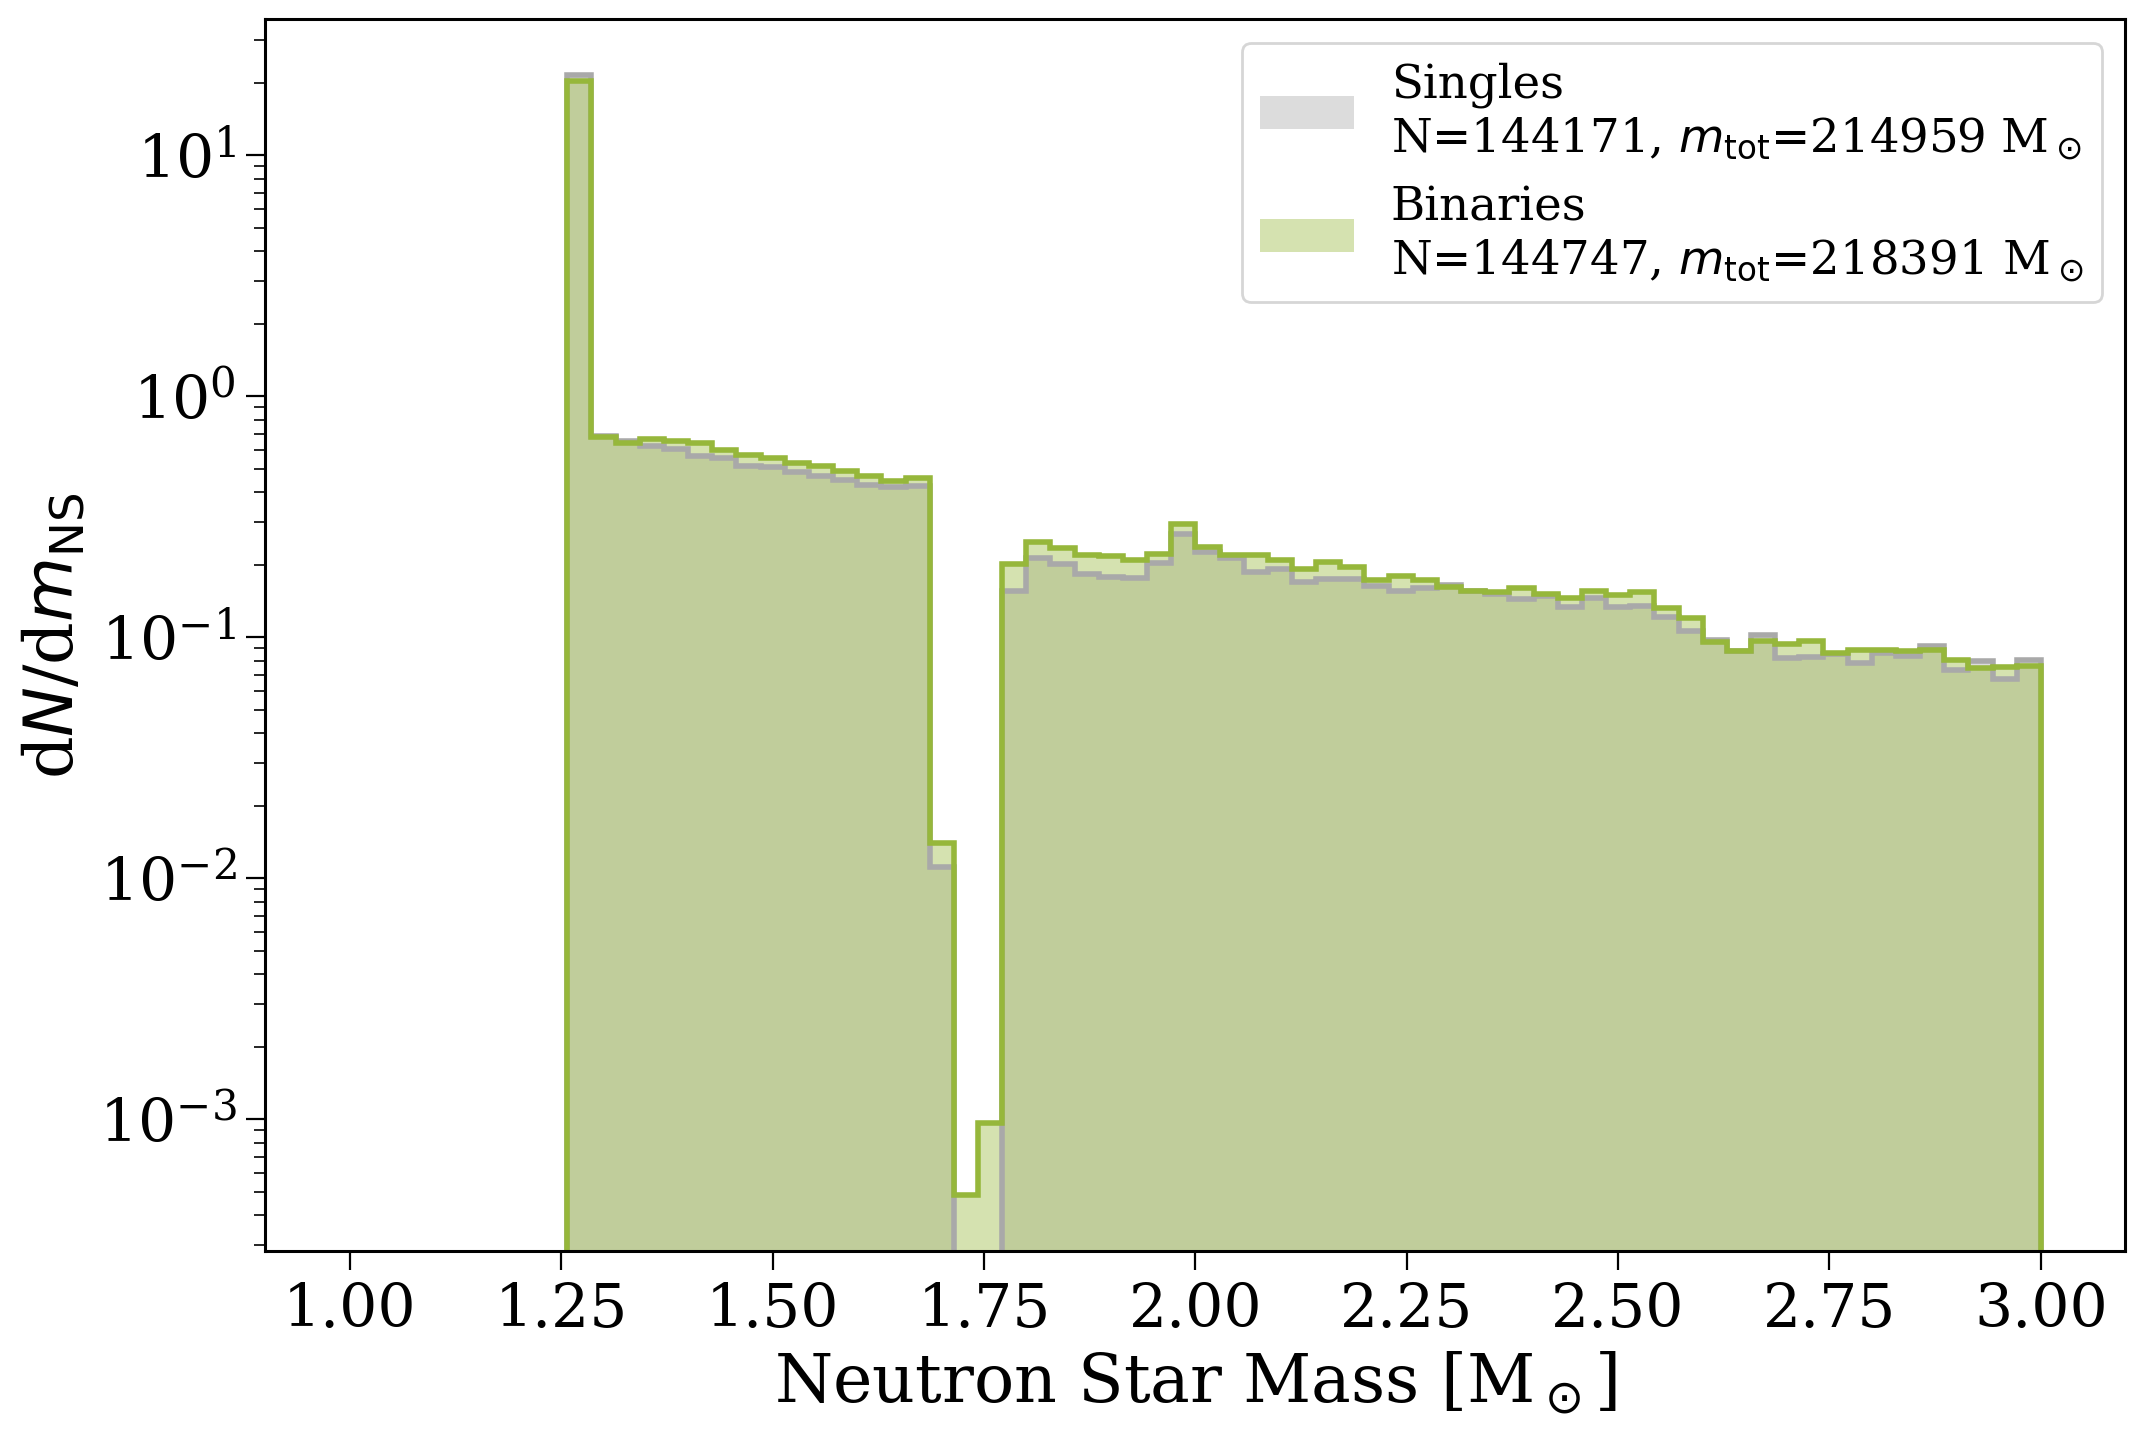

In [12]:
fig, ax = plt.subplots()

bins = np.linspace(1, 3, 71)

for pop in [singles, binaries]:
    ns_masses = np.concatenate(
        (pop.final_bpp["mass_1"][pop.final_bpp["kstar_1"] == 13], 
         pop.final_bpp["mass_2"][pop.final_bpp["kstar_2"] == 13])
    )
    print(sum(ns_masses), len(ns_masses))


    ax.hist(ns_masses, bins=bins, color=pop.colour, lw=2, histtype='step', density=True)
    ax.hist(ns_masses, bins=bins, color=pop.colour, alpha=0.4, density=True, label=f"{pop.label}\nN={len(ns_masses)}, $m_{{\\rm tot}}$={sum(ns_masses):.0f} M$_\odot$")

ax.set(
    xlabel="Neutron Star Mass [M$_\odot$]",
    ylabel=r"d$N$/d$m_{\rm NS}$",
    yscale='log',
)
ax.legend()

plt.show()

# Kinematics
## Scale heights

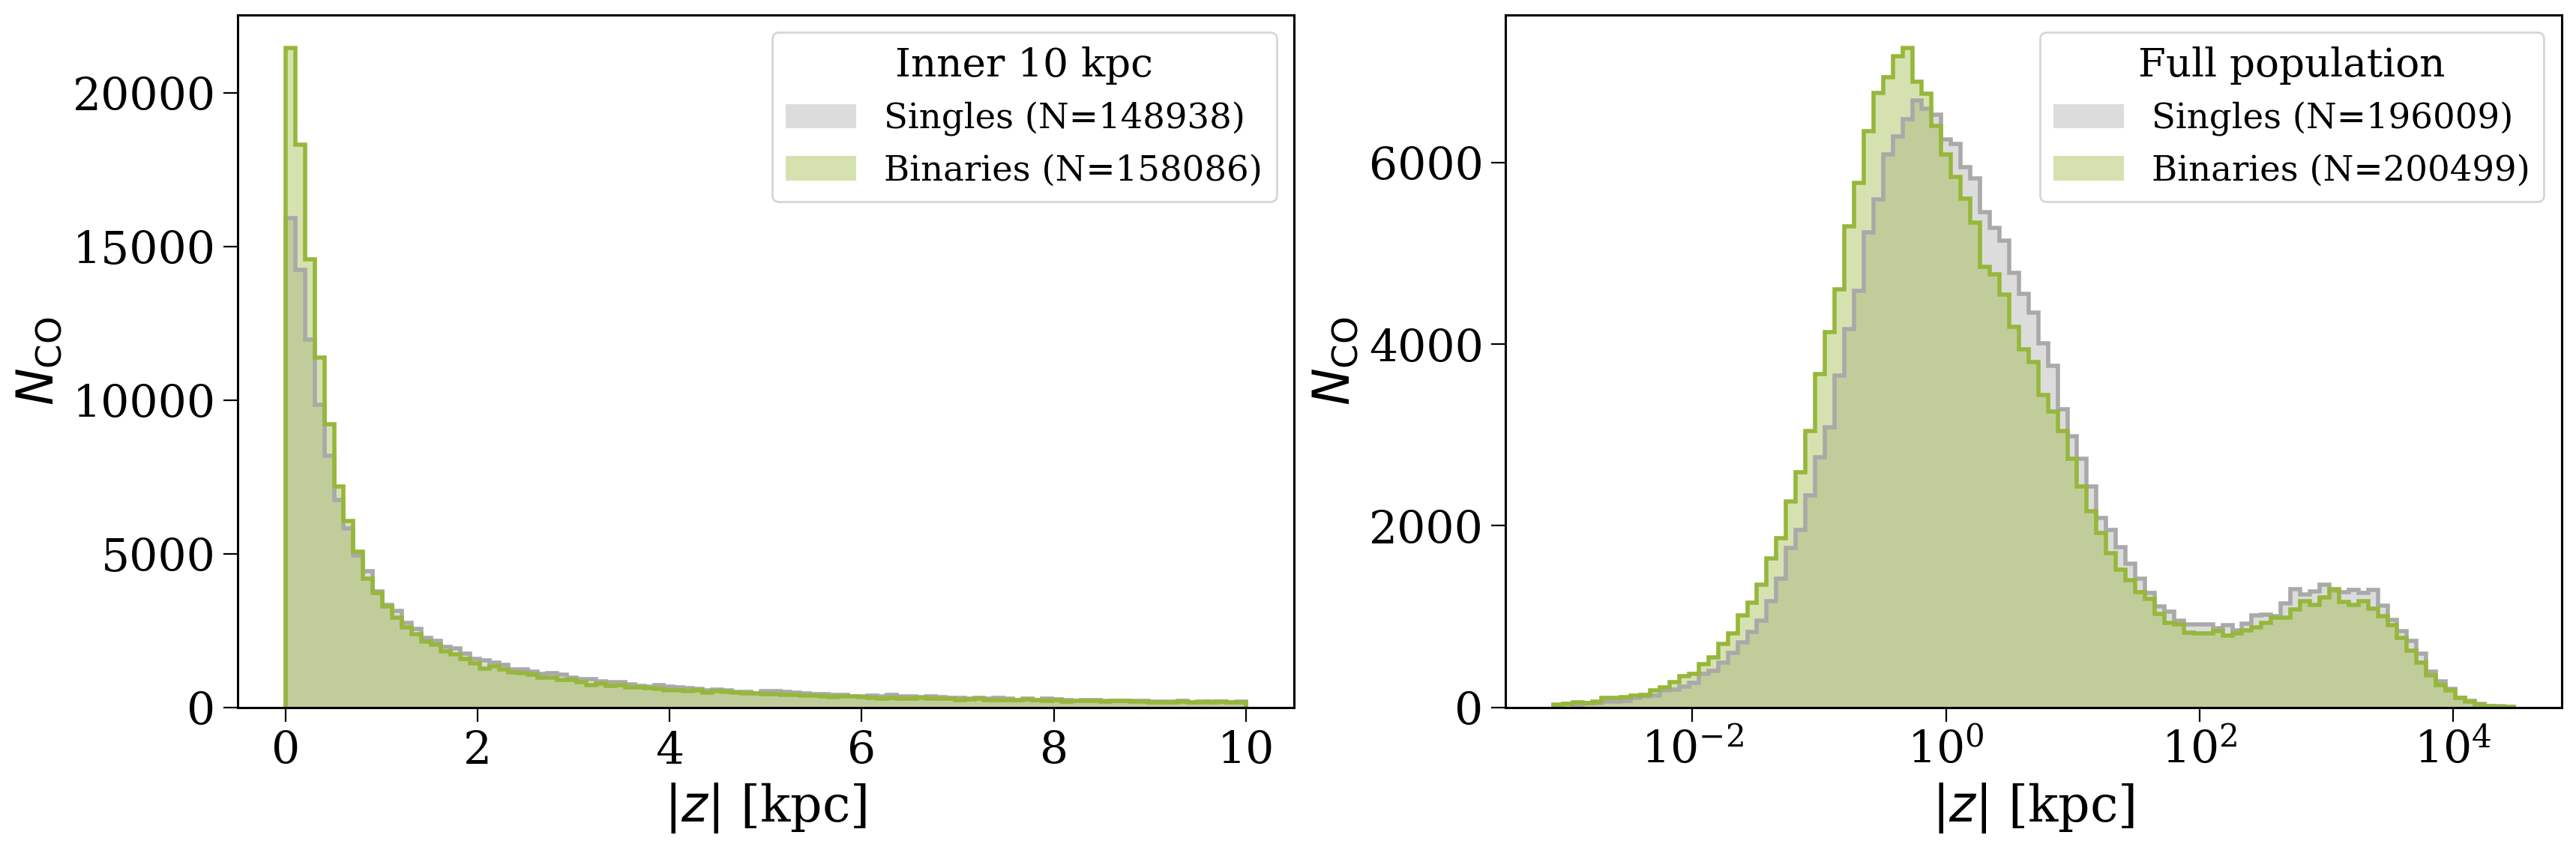

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

scales = ['linear', 'log']
bin_list = [np.linspace(0, 10, 100), np.geomspace(8e-4, 3e4, 100)]
labels = ['Inner 10 kpc', 'Full population']

for ax, scale, bins, label in zip(axes, scales, bin_list, labels):
    for pop in [singles, binaries]:
        primary_pos = pop.final_pos[:len(pop)]
        secondary_pos = pop.final_pos[:len(pop)].copy()
        secondary_pos[pop.disrupted] = pop.final_pos[len(pop):]

        ns_pos = np.concatenate((primary_pos[pop.final_bpp["kstar_1"] == 13],
                                secondary_pos[pop.final_bpp["kstar_2"] == 13]))
        bh_pos = np.concatenate((primary_pos[pop.final_bpp["kstar_1"] == 14],
                                secondary_pos[pop.final_bpp["kstar_2"] == 14]))
        co_pos = np.concatenate((ns_pos, bh_pos))

        mask = np.abs(co_pos[:, 2].to(u.kpc).value) < bins[-1]

        ax.hist(np.abs(co_pos[:, 2].to(u.kpc).value), bins=bins, histtype='step', lw=2, color=pop.colour)
        ax.hist(np.abs(co_pos[:, 2].to(u.kpc).value), bins=bins, alpha=0.4, color=pop.colour,
                label=f'{pop.label} (N={len(co_pos[mask])})')

    ax.set(
        xscale=scale,
        xlabel=r'$|z|$ [kpc]',
        ylabel=r'$N_{\rm CO}$',
    )
    ax.legend(title=label)
plt.show()

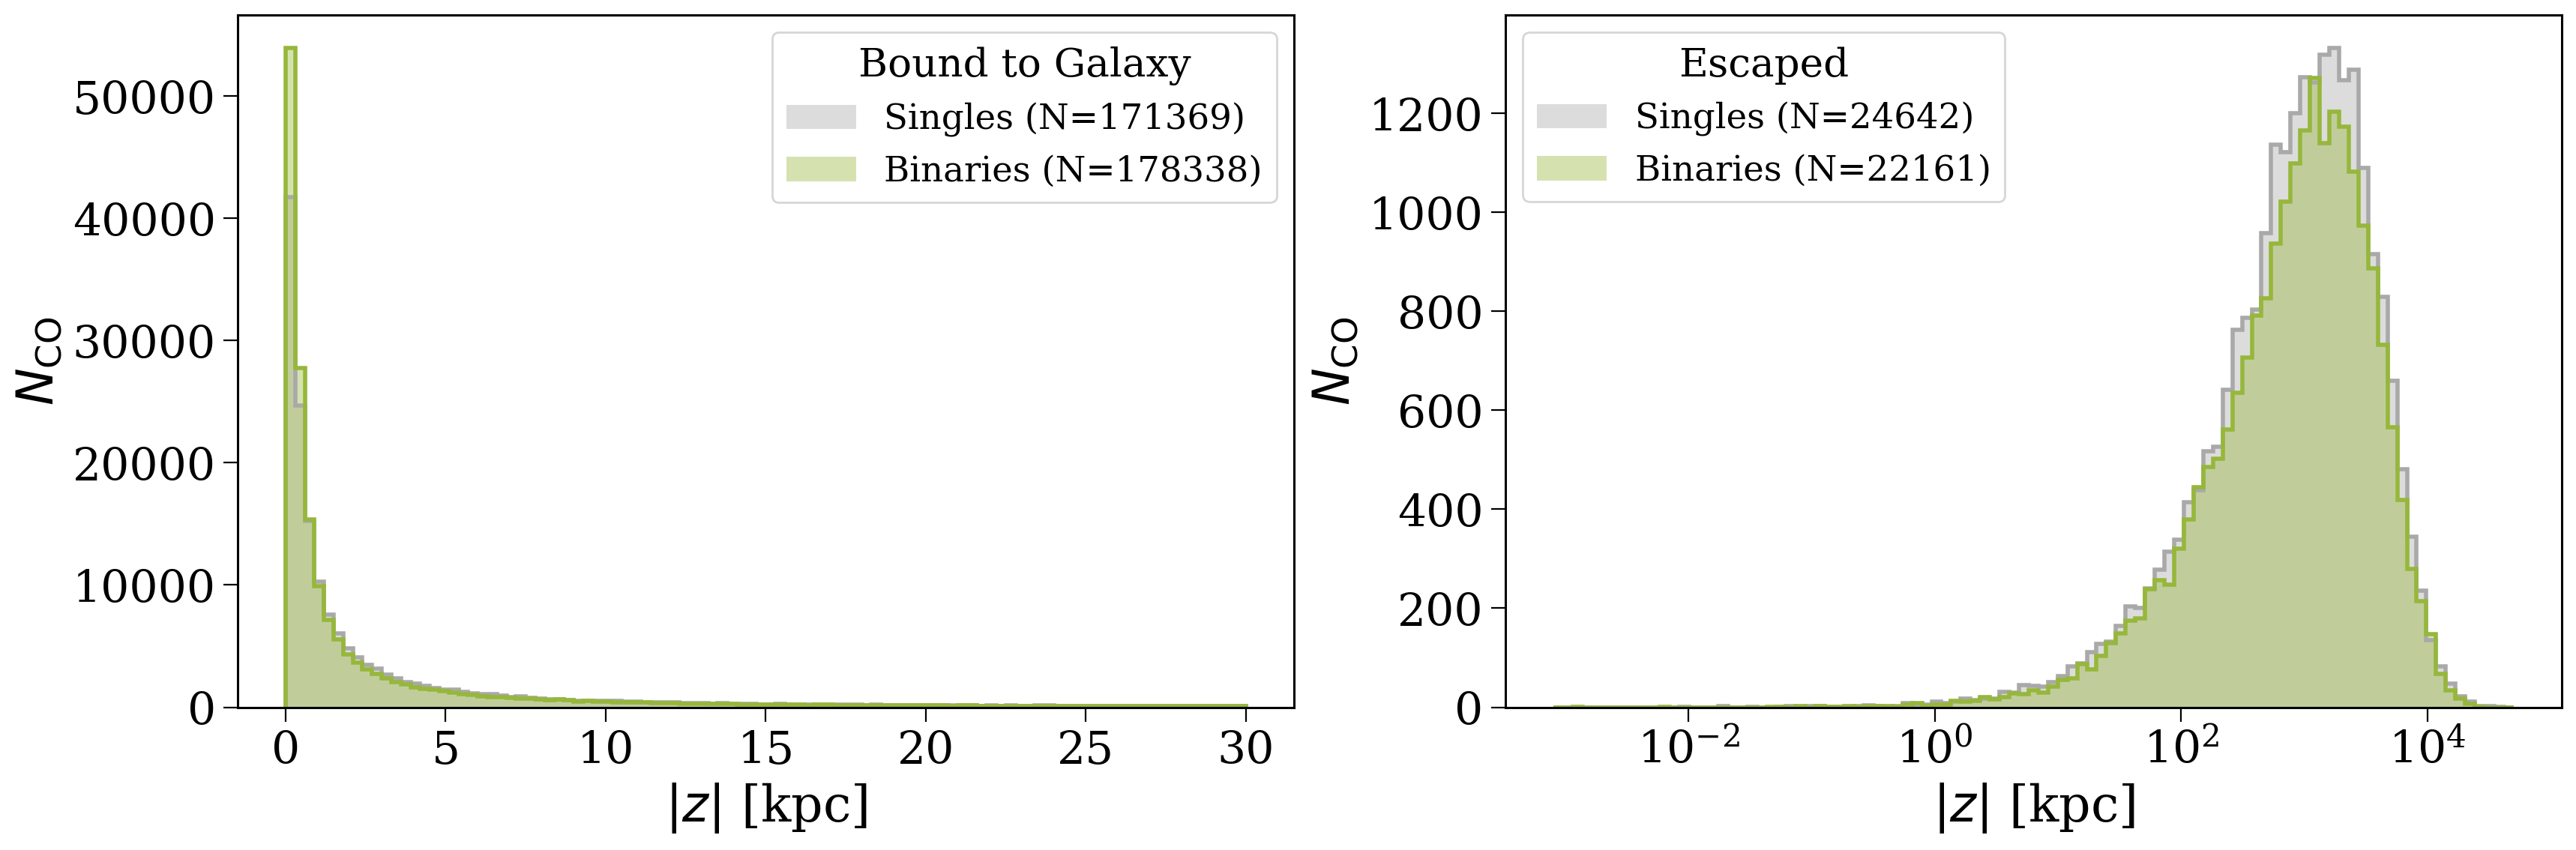

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

scales = ['linear', 'log']
bin_list = [np.linspace(0, 30, 101), np.geomspace(8e-4, 5e4, 100)]
labels = ['Bound to Galaxy', "Escaped"]

for ax, scale, bins, label in zip(axes, scales, bin_list, labels):
    for pop in [singles, binaries]:
        primary_pos = pop.final_pos[:len(pop)]
        secondary_pos = pop.final_pos[:len(pop)].copy()
        secondary_pos[pop.disrupted] = pop.final_pos[len(pop):]

        ns_pos = np.concatenate((primary_pos[pop.final_bpp["kstar_1"] == 13],
                                secondary_pos[pop.final_bpp["kstar_2"] == 13]))
        bh_pos = np.concatenate((primary_pos[pop.final_bpp["kstar_1"] == 14],
                                secondary_pos[pop.final_bpp["kstar_2"] == 14]))
        co_pos = np.concatenate((ns_pos, bh_pos))

        primary_vel = pop.final_vel[:len(pop)]
        secondary_vel = pop.final_vel[:len(pop)].copy()
        secondary_vel[pop.disrupted] = pop.final_vel[len(pop):]
        ns_vel = np.concatenate((primary_vel[pop.final_bpp["kstar_1"] == 13],
                                 secondary_vel[pop.final_bpp["kstar_2"] == 13]))
        bh_vel = np.concatenate((primary_vel[pop.final_bpp["kstar_1"] == 14],
                                 secondary_vel[pop.final_bpp["kstar_2"] == 14]))
        co_vel = np.concatenate((ns_vel, bh_vel))

        co_V = np.linalg.norm(co_vel.to(u.km/u.s).value, axis=1)

        mask = co_V >= np.sqrt(-2 * pop.galactic_potential(co_pos.T)).to(u.km / u.s).value
        mask = mask if label == "Escaped" else ~mask

        ax.hist(np.abs(co_pos[:, 2].to(u.kpc).value)[mask], bins=bins, histtype='step', lw=2, color=pop.colour)
        ax.hist(np.abs(co_pos[:, 2].to(u.kpc).value)[mask], bins=bins, alpha=0.4, color=pop.colour,
                label=f'{pop.label} (N={len(co_pos[mask])})')

    ax.set(
        xscale=scale,
        xlabel=r'$|z|$ [kpc]',
        ylabel=r'$N_{\rm CO}$',
    )
    ax.legend(title=label)
plt.show()

In [15]:
import seaborn as sns

In [16]:
stars = cogsworth.sfh.SandersBinney2015(
    size=200000,
    **{
        "potential": binaries.galactic_potential,
        "time_bins": 5,
        "verbose": True
    }
)

Pre-computing lookback time, guiding radius and frequency interpolations
Initiating sampling procedure
  Sampling 162119 stars from the thin_disc
    Sampling 19471 stars with lookback times between 0.00 Gyr and 2.00 Gyr
    Sampling 24468 stars with lookback times between 2.00 Gyr and 4.00 Gyr
    Sampling 31445 stars with lookback times between 4.00 Gyr and 6.00 Gyr
    Sampling 39362 stars with lookback times between 6.00 Gyr and 8.00 Gyr
    Sampling 47373 stars with lookback times between 8.00 Gyr and 10.00 Gyr
  Sampling 37881 stars from the thick_disc
    Sampling 37881 stars with lookback times between 10.00 Gyr and 12.00 Gyr


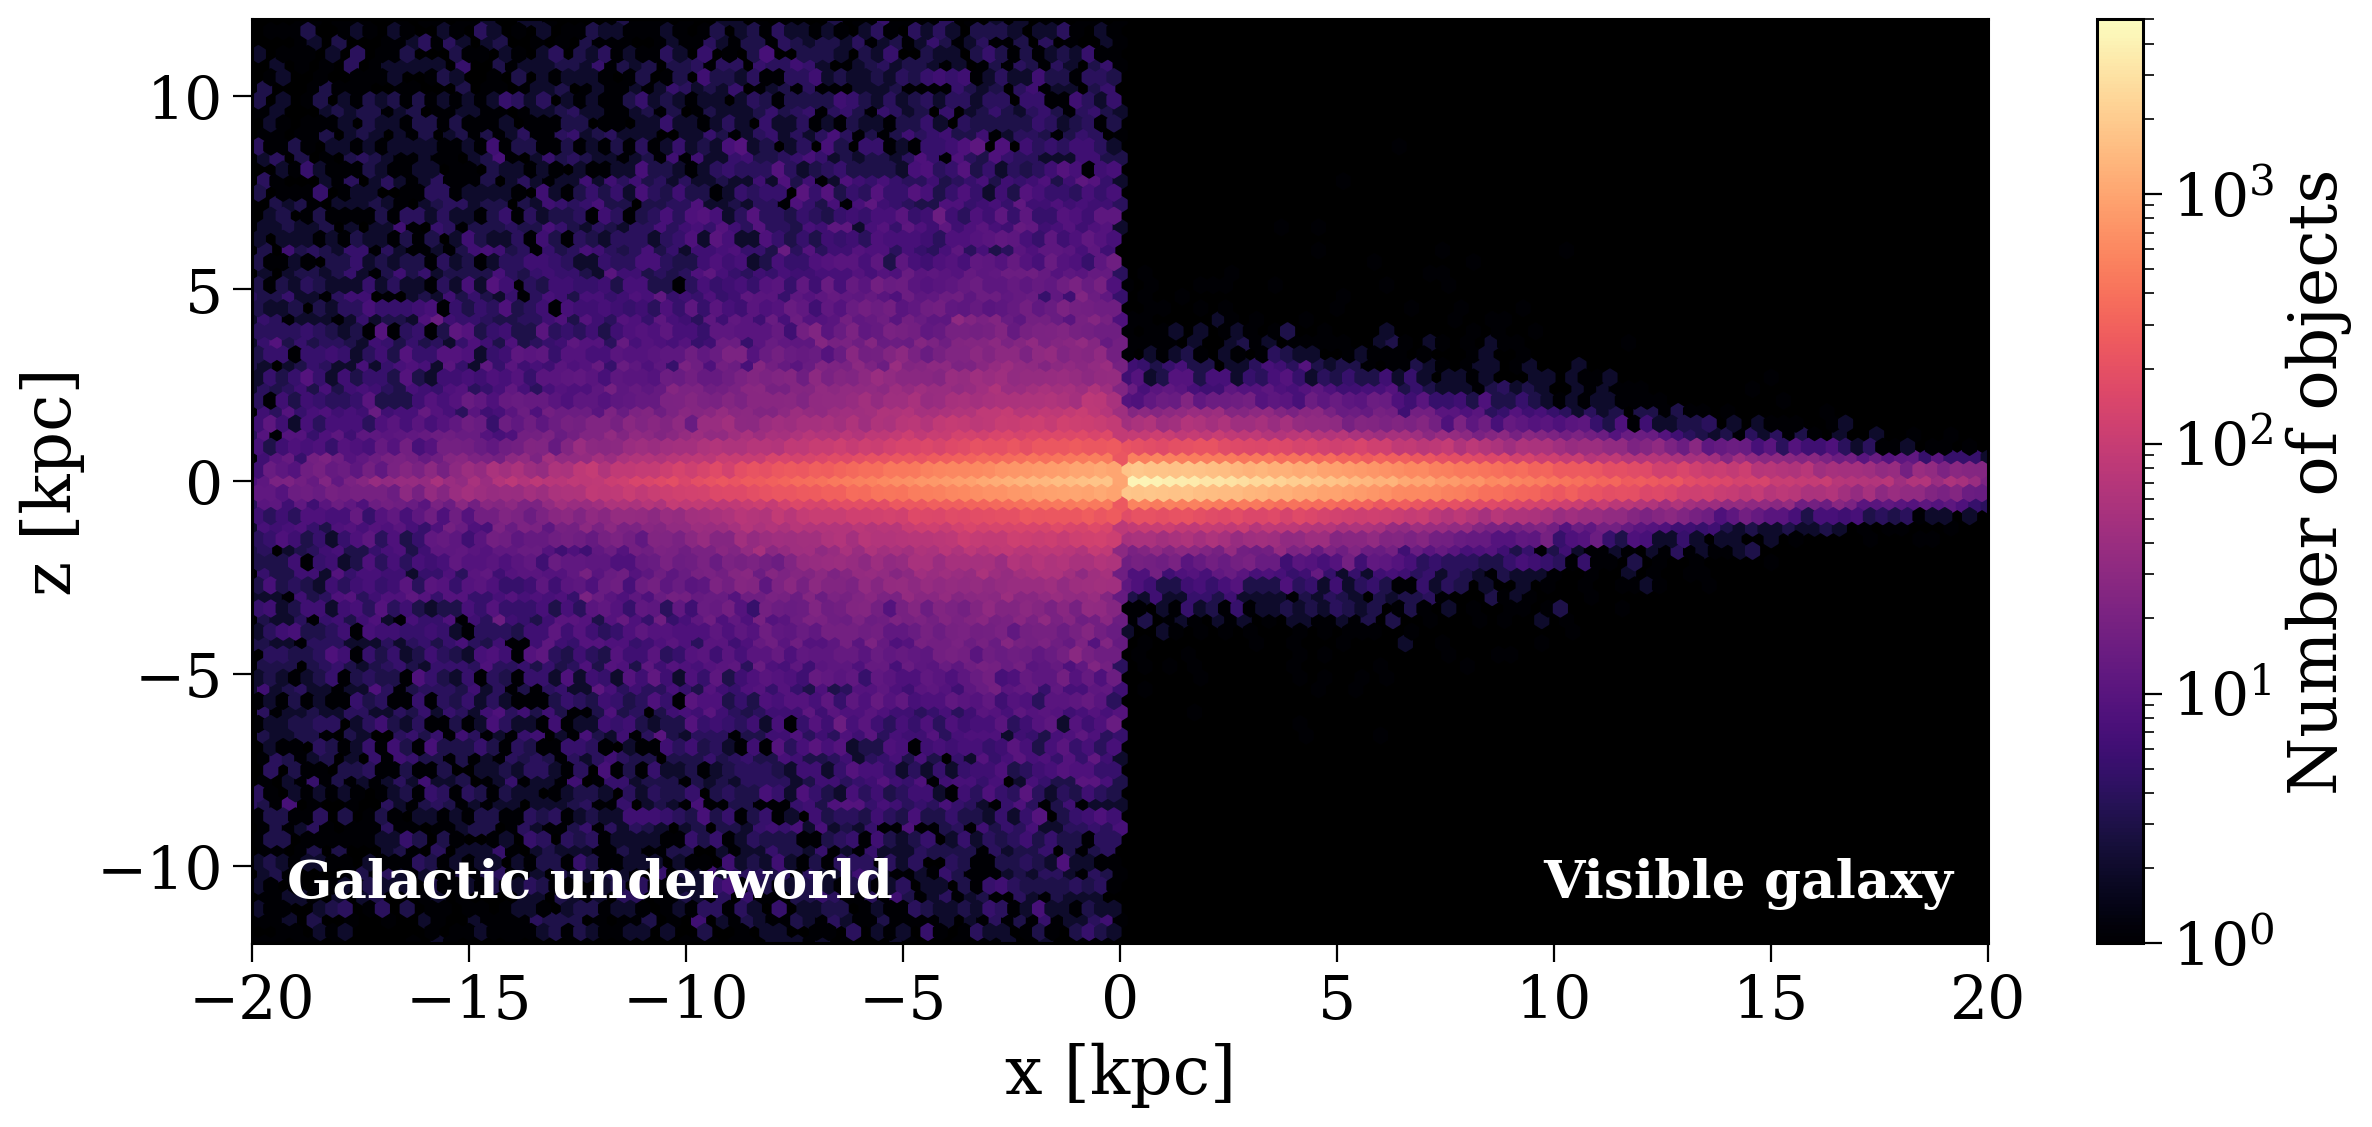

In [17]:
initial_galaxy = pd.read_hdf(binaries._file, "initial_galaxy")
initial_galaxy.index = binaries.bin_nums
init_x, init_z = initial_galaxy["x"], initial_galaxy["z"]

ZLIM = 12
XLIM = 20

EVERY = 50

fig, ax = plt.subplots(figsize=(14, 6))

for x, z, extent in zip([np.abs(stars.x.to(u.kpc).value), -np.abs(co_pos[:, 0].to(u.kpc).value)],
                        [stars.z.to(u.kpc).value, co_pos[:, 2].to(u.kpc).value],
                        [[0, XLIM, -ZLIM, ZLIM], [-XLIM, 0, -ZLIM, ZLIM]]):
    mask = (np.abs(z) < ZLIM) & (np.abs(x) < XLIM)
    x = x[mask]
    z = z[mask]

    hexbin = ax.hexbin(x, z, gridsize=70, mincnt=1, extent=extent, cmap='magma', bins='log', vmin=1, vmax=5000)
    # sns.kdeplot(
    #     x=x[::EVERY],
    #     y=z[::EVERY],
    #     fill=False,
    #     levels=[0.05, 0.25, 0.7, 1.0],
    #     color='cyan',
    #     linewidths=2,
    #     alpha=0.7,
    # )

    ax.annotate(
        'Galactic underworld' if extent[0] == 0 else 'Visible galaxy',
        xy=(0.02 if extent[0] == 0 else 0.98, 0.05),
        ha='left' if extent[0] == 0 else 'right',
        xycoords='axes fraction',
        color='white',
        fontsize=0.8*fs,
        weight='bold'
    )

fig.colorbar(hexbin, label='Number of objects')

ax.set(
    xlim=(-XLIM, XLIM),
    ylim=(-ZLIM, ZLIM),
    xlabel='x [kpc]',
    ylabel='z [kpc]',
)
# set background to black
ax.set_facecolor('black')
plt.show()

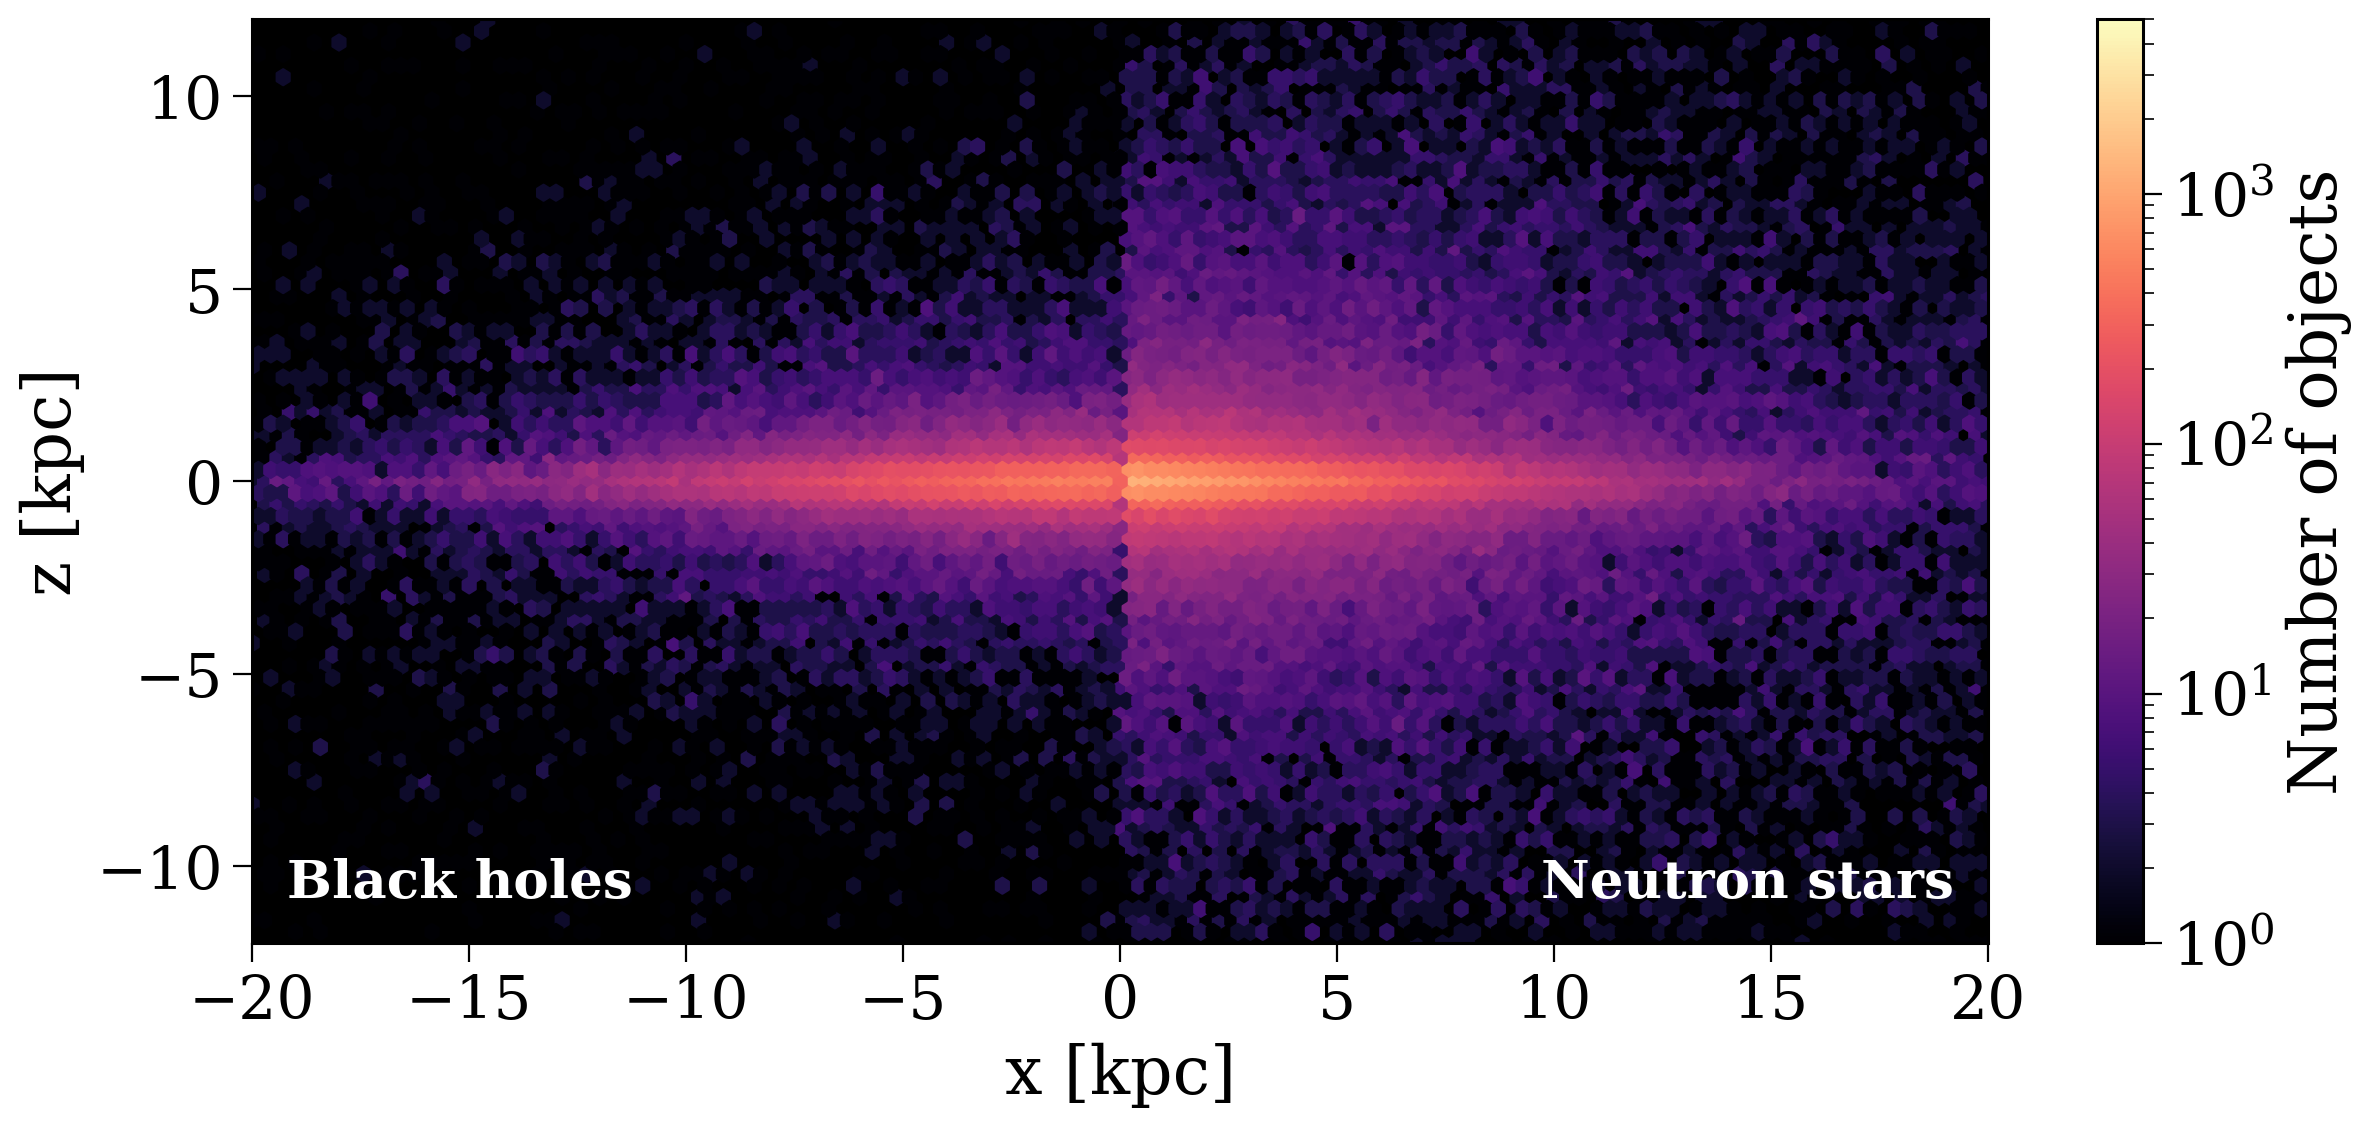

In [18]:
initial_galaxy = pd.read_hdf(binaries._file, "initial_galaxy")
initial_galaxy.index = binaries.bin_nums
init_x, init_z = initial_galaxy["x"], initial_galaxy["z"]

ZLIM = 12
XLIM = 20

EVERY = 50

fig, ax = plt.subplots(figsize=(14, 6))

for x, z, extent in zip([np.abs(ns_pos[:, 0].to(u.kpc).value), -np.abs(bh_pos[:, 0].to(u.kpc).value)],
                        [ns_pos[:, 2].to(u.kpc).value, bh_pos[:, 2].to(u.kpc).value],
                        [[0, XLIM, -ZLIM, ZLIM], [-XLIM, 0, -ZLIM, ZLIM]]):
    mask = (np.abs(z) < ZLIM) & (np.abs(x) < XLIM)
    x = x[mask]
    z = z[mask]

    hexbin = ax.hexbin(x, z, gridsize=70, mincnt=1, extent=extent, cmap='magma', bins='log', vmin=1, vmax=5000)
    # sns.kdeplot(
    #     x=x[::EVERY],
    #     y=z[::EVERY],
    #     fill=False,
    #     levels=[0.05, 0.25, 0.7, 1.0],
    #     color='cyan',
    #     linewidths=2,
    #     alpha=0.7,
    # )

    ax.annotate(
        'Black holes' if extent[0] == 0 else 'Neutron stars',
        xy=(0.02 if extent[0] == 0 else 0.98, 0.05),
        ha='left' if extent[0] == 0 else 'right',
        xycoords='axes fraction',
        color='white',
        fontsize=0.8*fs,
        weight='bold'
    )

fig.colorbar(hexbin, label='Number of objects')

ax.set(
    xlim=(-XLIM, XLIM),
    ylim=(-ZLIM, ZLIM),
    xlabel='x [kpc]',
    ylabel='z [kpc]',
)
# set background to black
ax.set_facecolor('black')
plt.show()

## Velocities

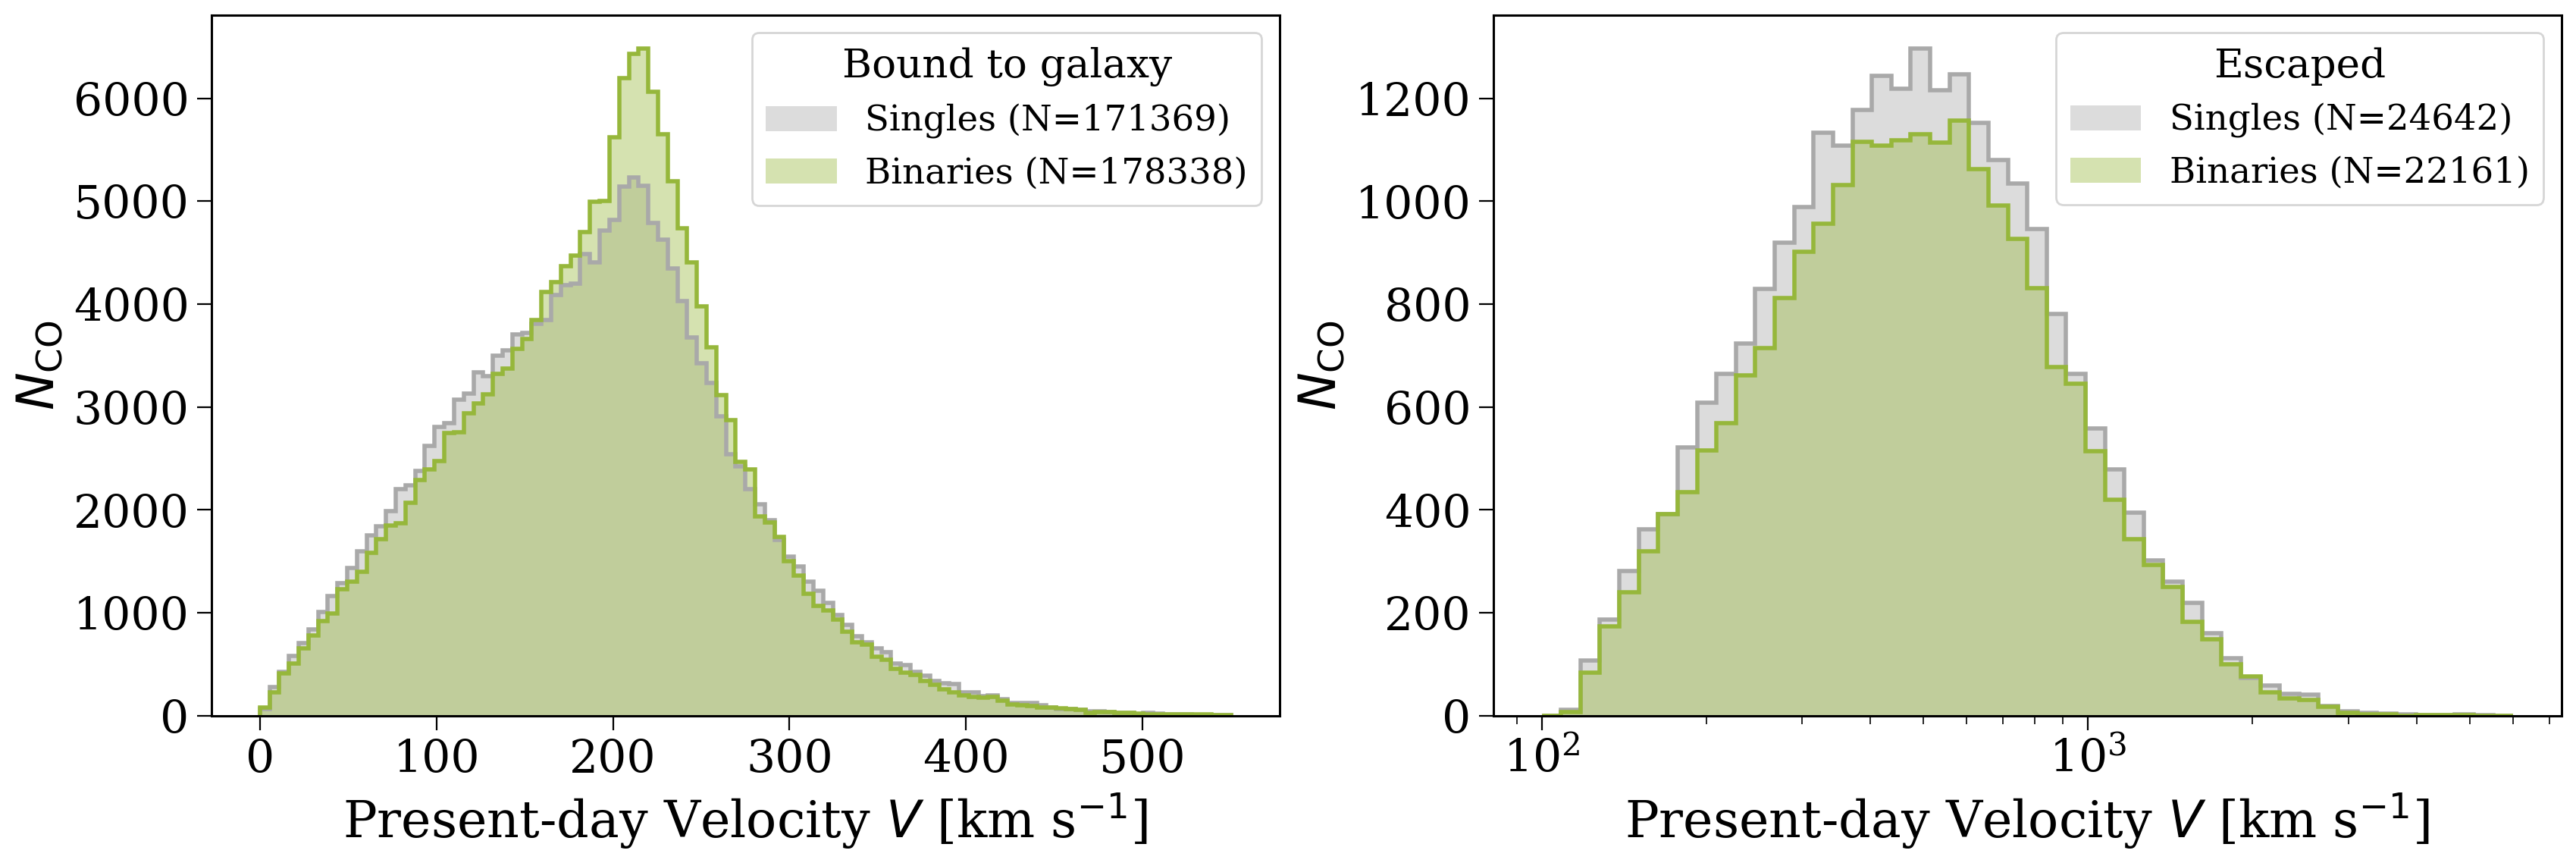

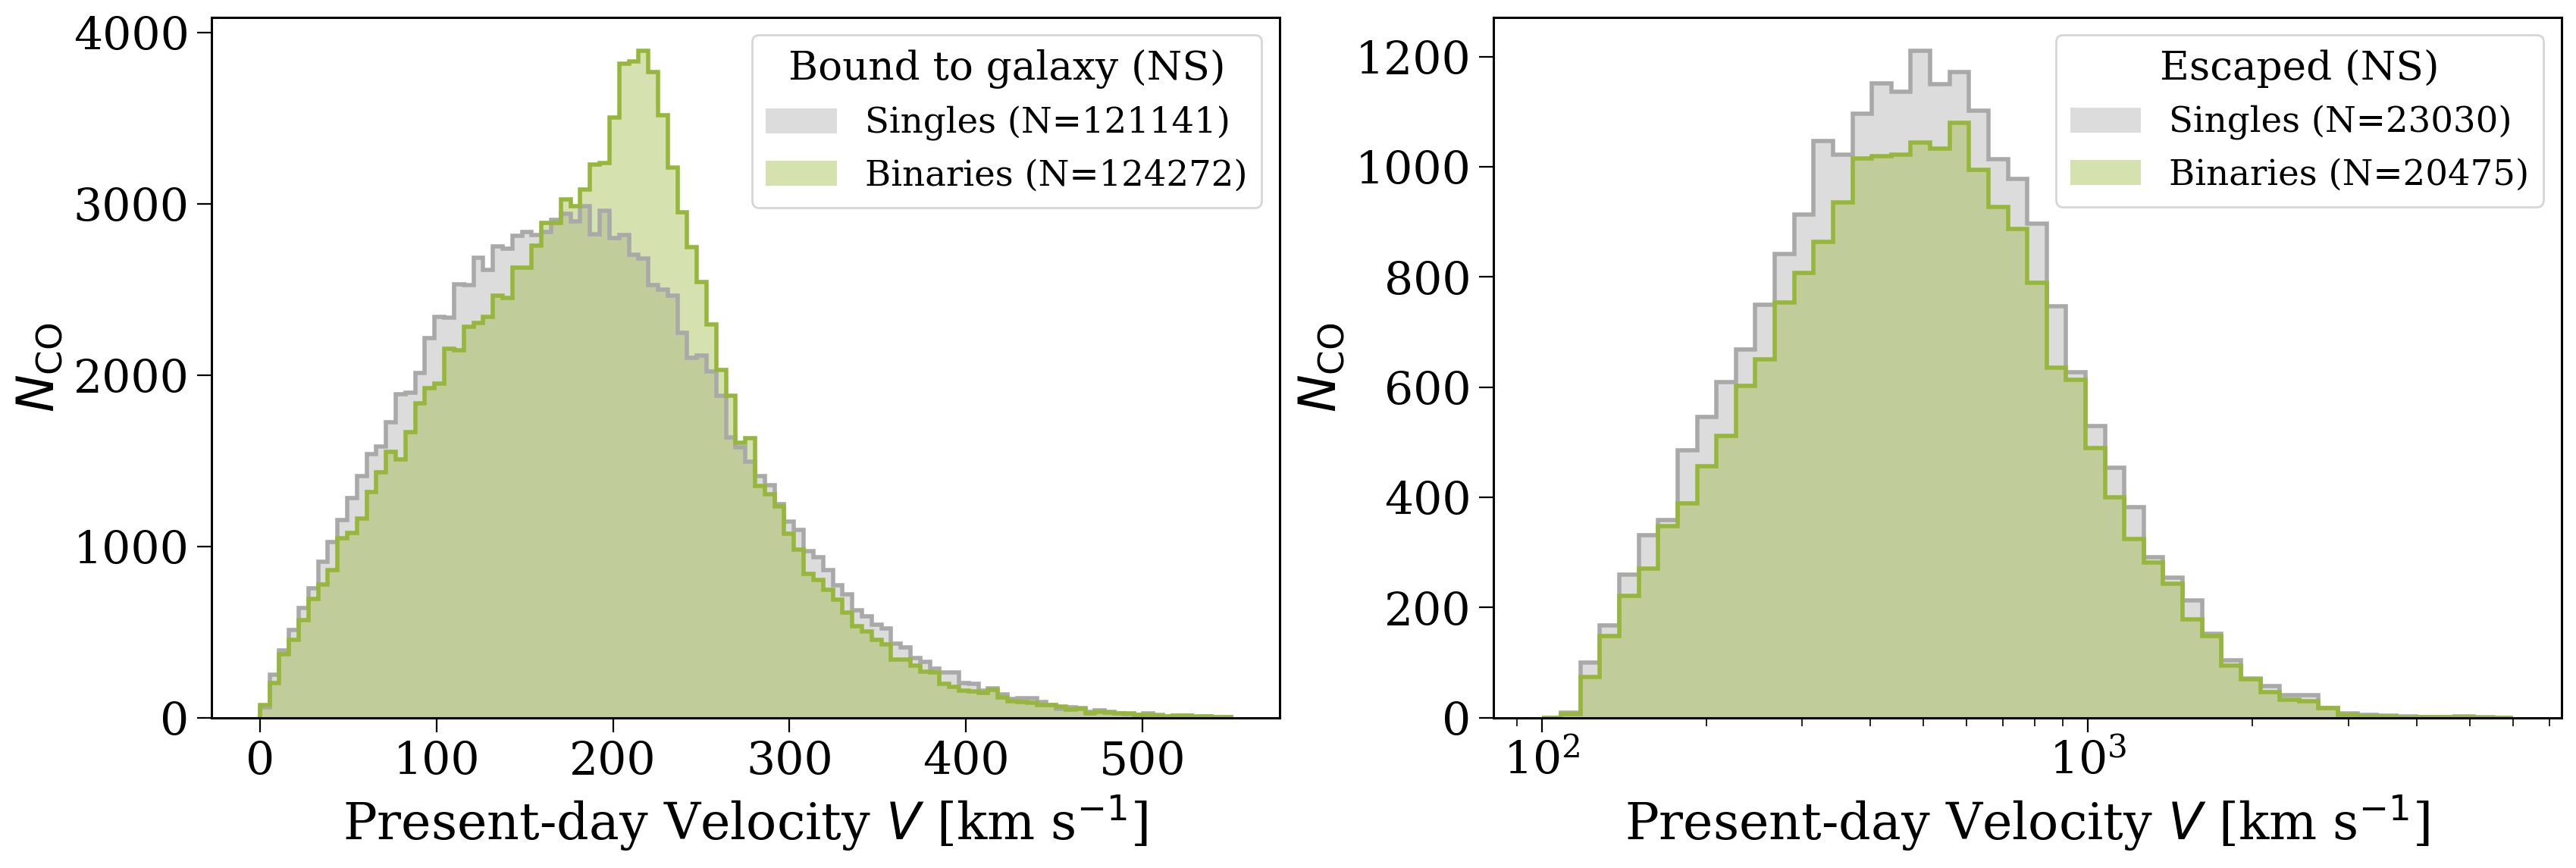

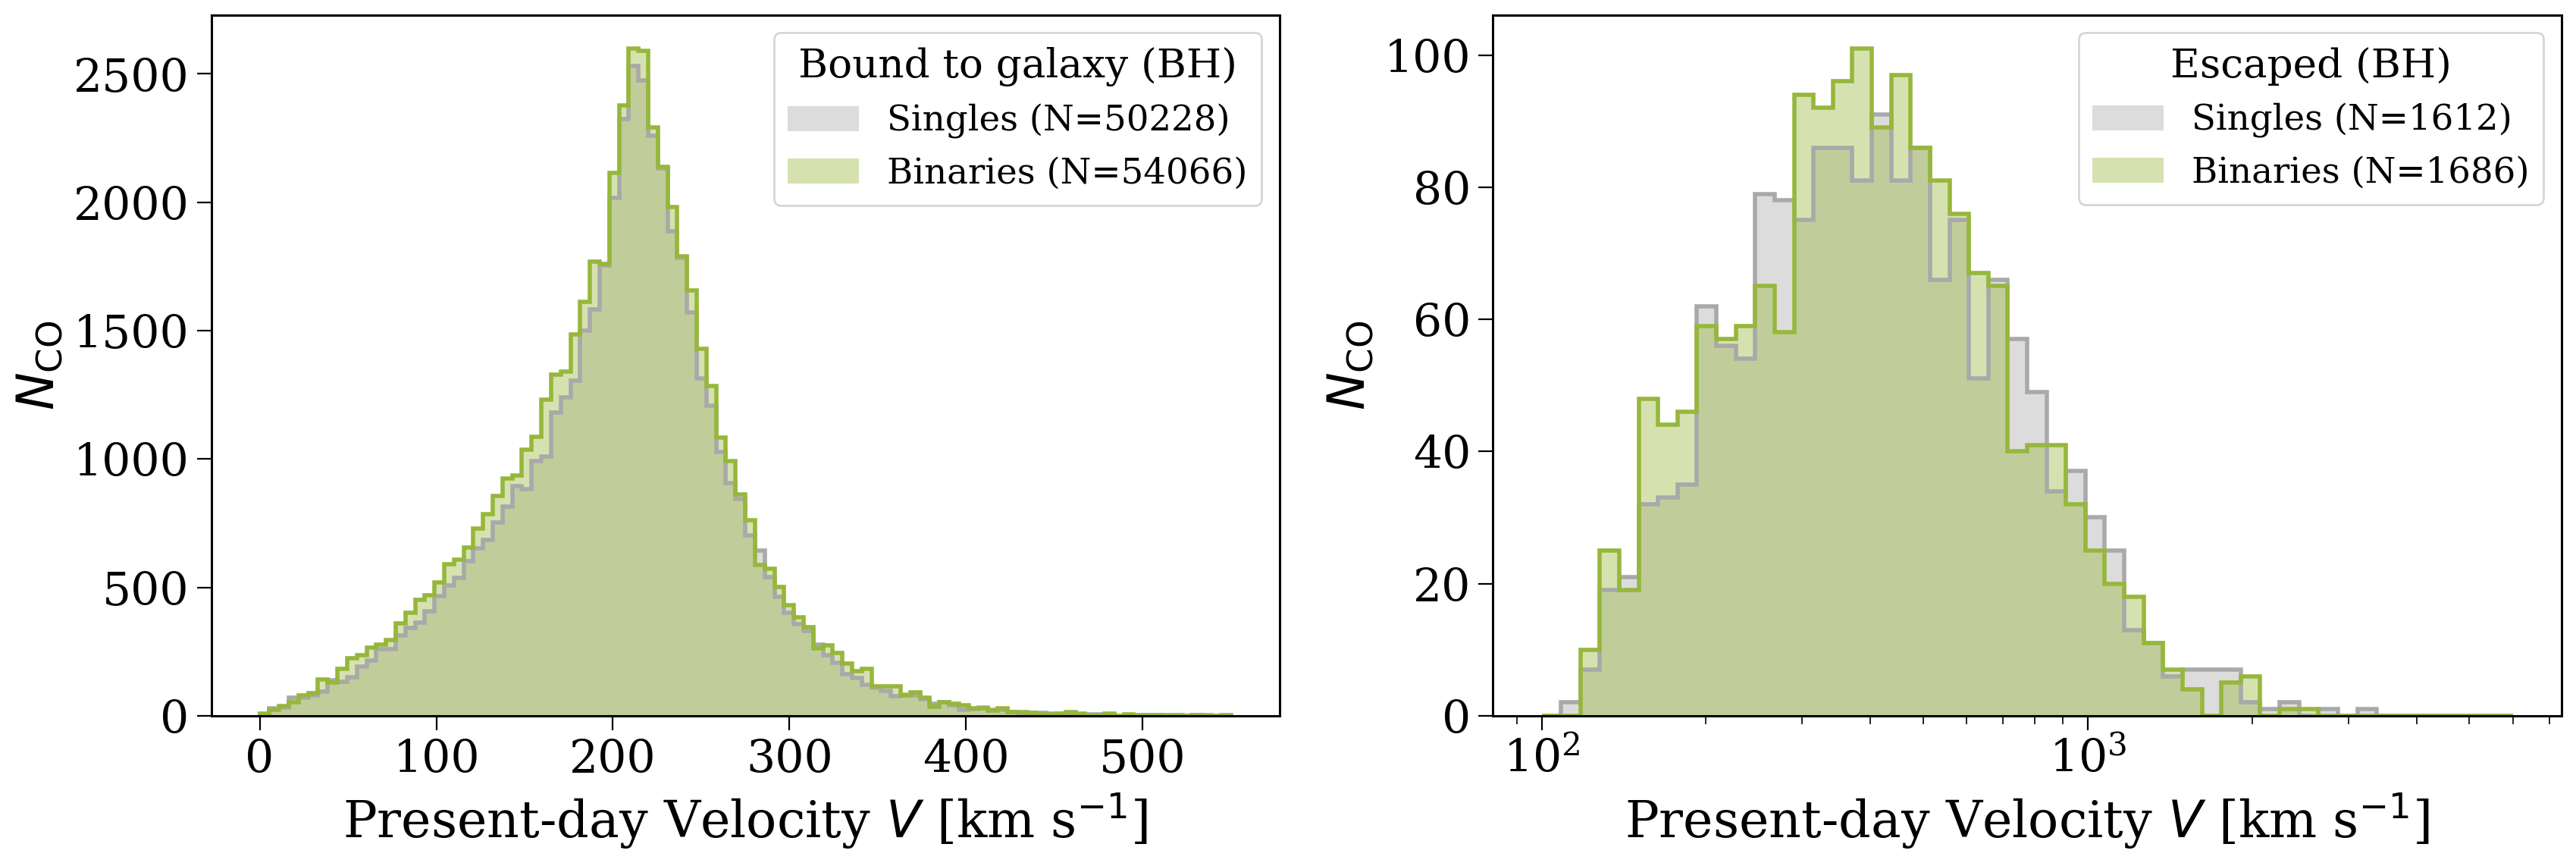

In [19]:
for co_type in ["ALL", "NS", "BH"]:

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    density = False

    for ax, label, bins, scale in zip(axes, ['Bound to galaxy', "Escaped"],
                                    [np.linspace(0, 550, 101), np.geomspace(1e2, 6e3, 51)], ['linear', 'log']):
        for pop in [singles, binaries]:
            primary_vel = pop.final_vel[:len(pop)]
            secondary_vel = pop.final_vel[:len(pop)].copy()
            secondary_vel[pop.disrupted] = pop.final_vel[len(pop):]
            
            ns_vel = np.concatenate((primary_vel[pop.final_bpp["kstar_1"] == 13],
                                    secondary_vel[pop.final_bpp["kstar_2"] == 13]))
            bh_vel = np.concatenate((primary_vel[pop.final_bpp["kstar_1"] == 14],
                                    secondary_vel[pop.final_bpp["kstar_2"] == 14]))
            co_vel = np.concatenate((ns_vel, bh_vel)) if co_type == "ALL" else (ns_vel if co_type == "NS" else bh_vel)

            primary_pos = pop.final_pos[:len(pop)]
            secondary_pos = pop.final_pos[:len(pop)].copy()
            secondary_pos[pop.disrupted] = pop.final_pos[len(pop):]

            ns_pos = np.concatenate((primary_pos[pop.final_bpp["kstar_1"] == 13],
                                    secondary_pos[pop.final_bpp["kstar_2"] == 13]))
            bh_pos = np.concatenate((primary_pos[pop.final_bpp["kstar_1"] == 14],
                                    secondary_pos[pop.final_bpp["kstar_2"] == 14]))
            co_pos = np.concatenate((ns_pos, bh_pos)) if co_type == "ALL" else (ns_pos if co_type == "NS" else bh_pos)

            co_V = np.linalg.norm(co_vel.to(u.km/u.s).value, axis=1)

            mask = co_V >= np.sqrt(-2 * pop.galactic_potential(co_pos.T)).to(u.km / u.s).value
            mask = mask if label == "Escaped" else ~mask
            co_V = co_V[mask]

            ax.hist(co_V, bins=bins, histtype='step', lw=2, color=pop.colour, density=density)
            ax.hist(co_V, bins=bins, alpha=0.4, color=pop.colour, density=density,
                    label=f'{pop.label} (N={len(co_V)})')

            ax.set(
                xlabel=r'Present-day Velocity $V$ [km s$^{-1}$]',
                ylabel=r'$N_{\rm CO}$',
                xscale=scale,
            )
            ax.legend(title=label + f" ({co_type})" if co_type != "ALL" else label)
    plt.show()

## Kicks

196011
13626 0.0695165067266633
200606
11777 0.05870711743417445


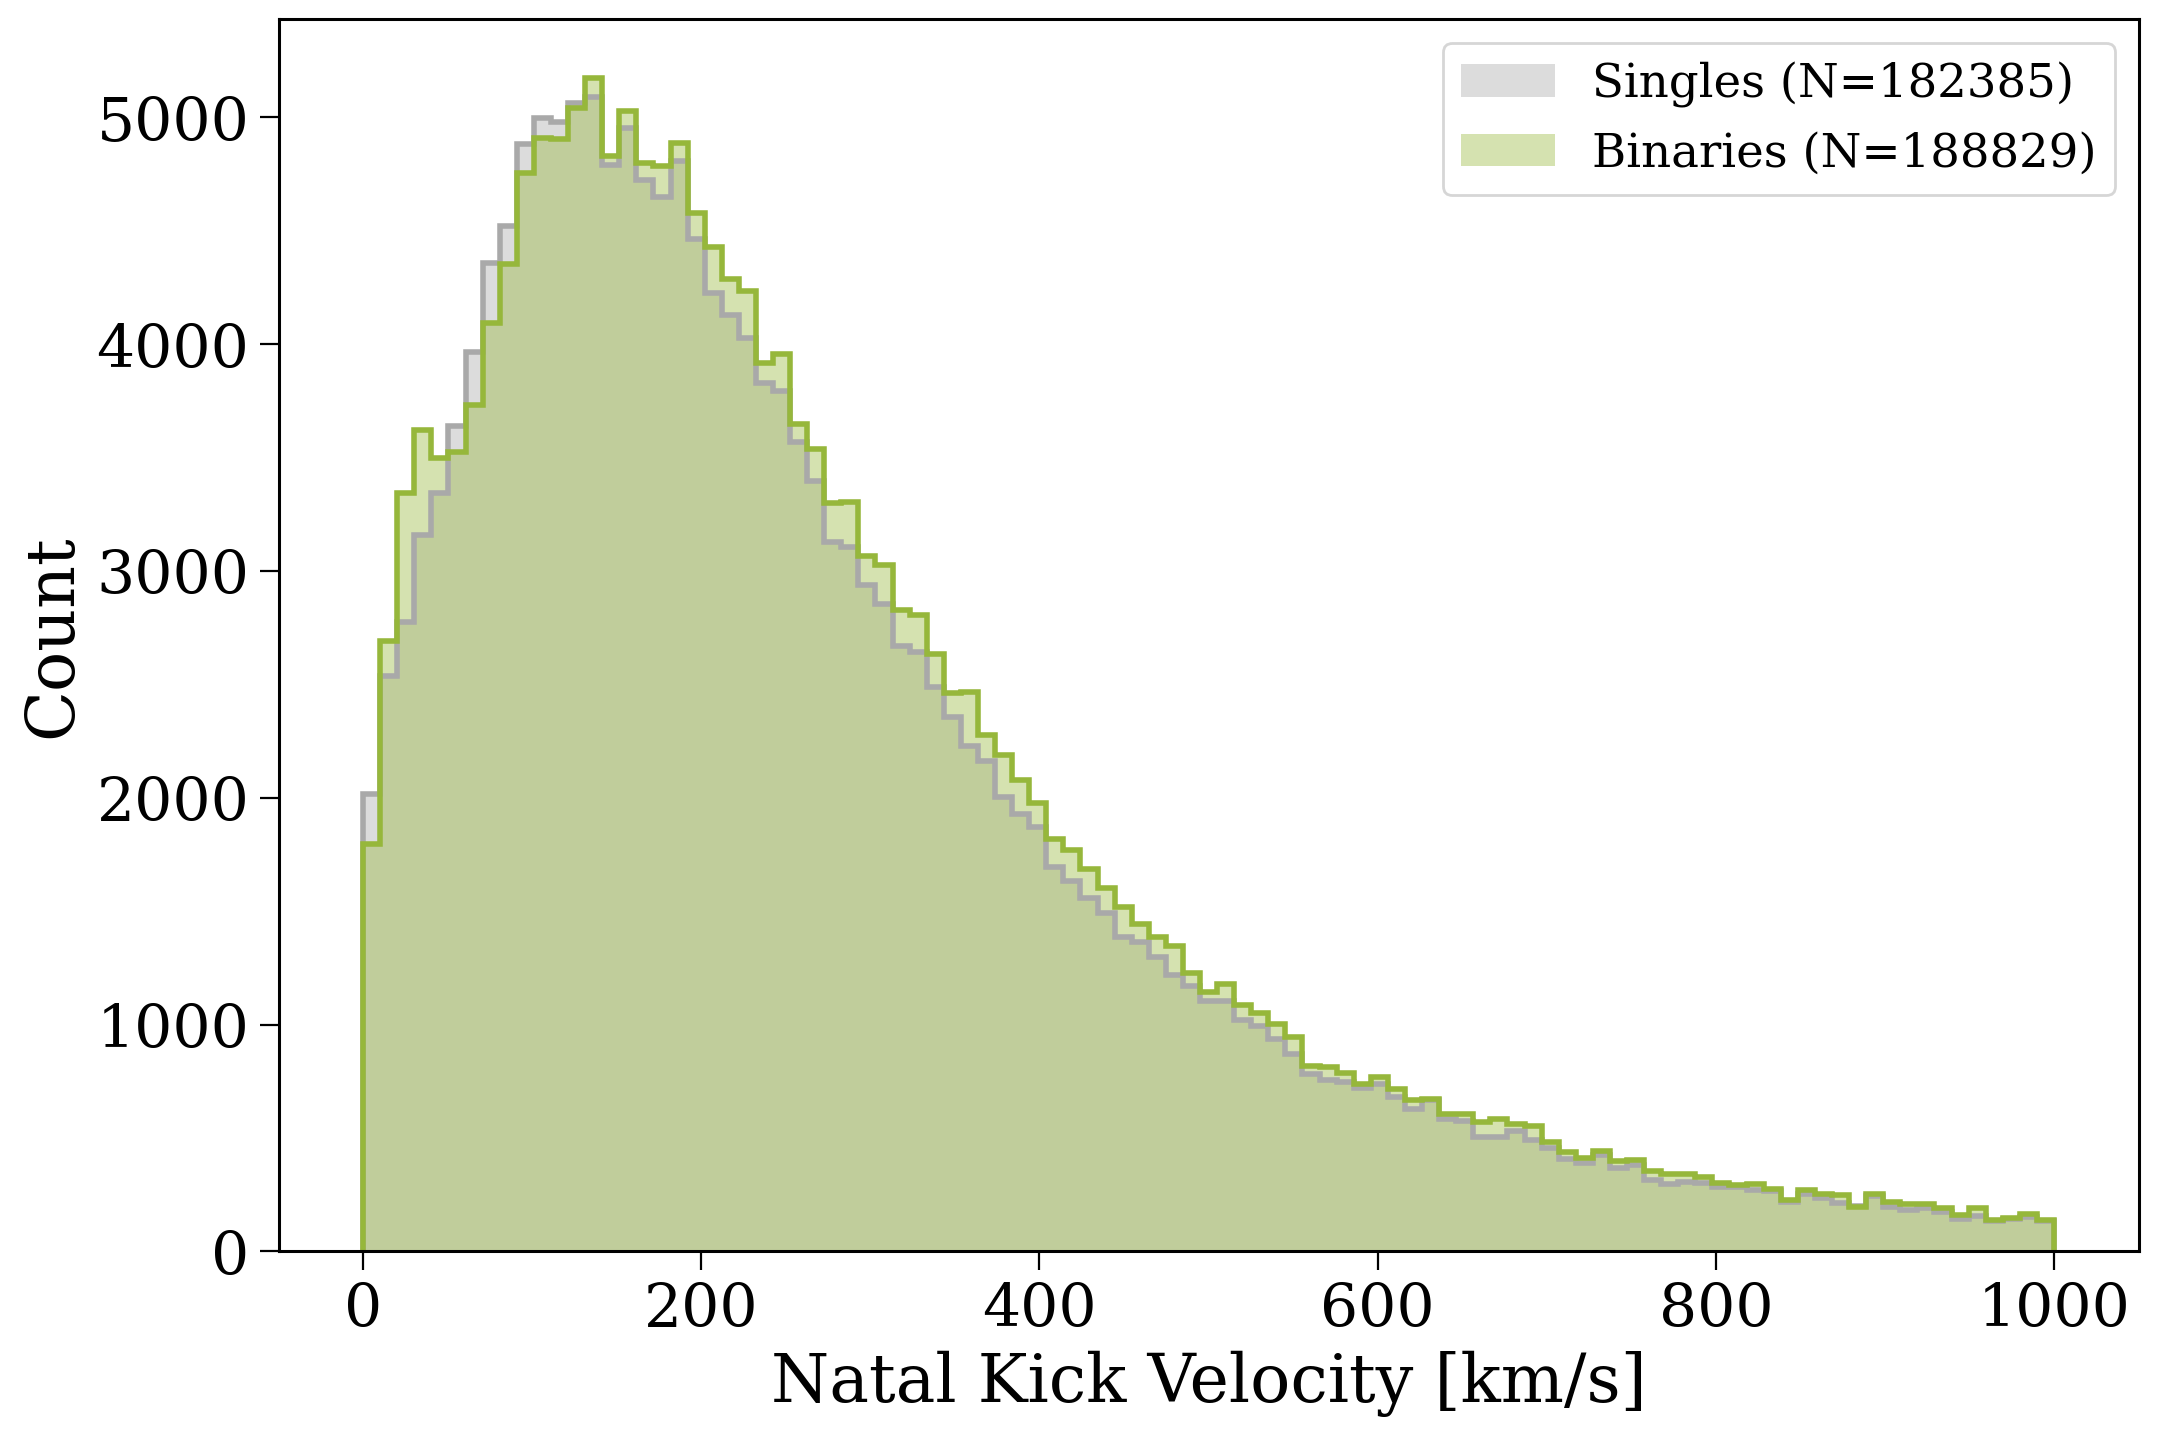

196011
286 0.001983755401571745
200606
0 0.0


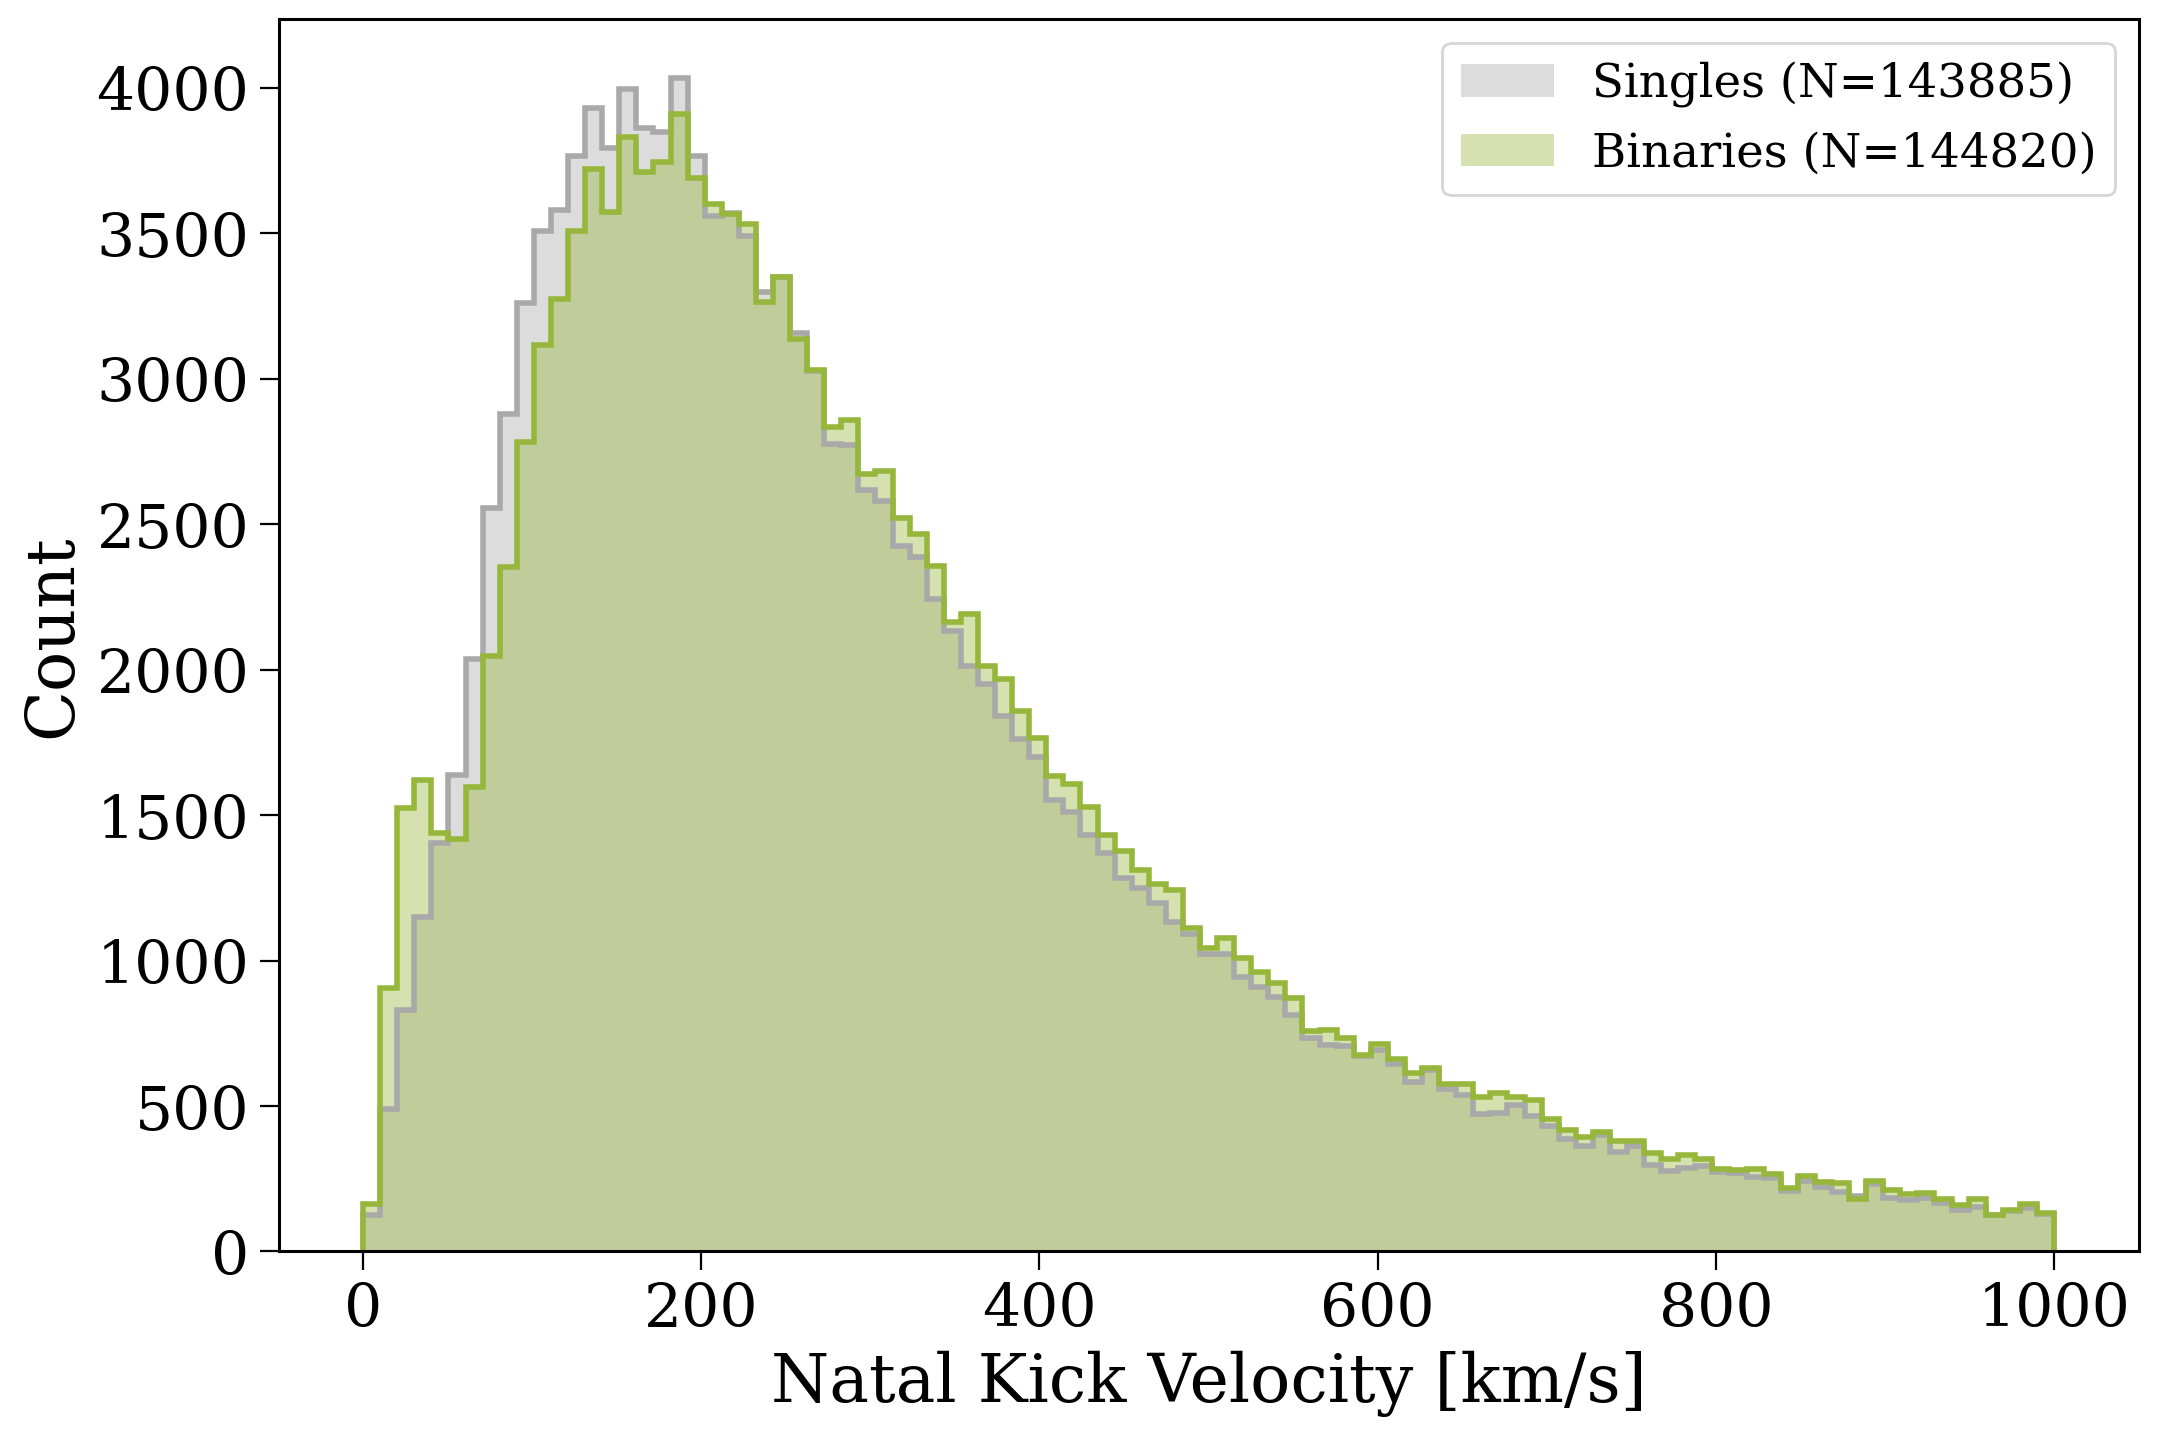

196011
13340 0.25733024691358025
200606
11777 0.21111031441580325


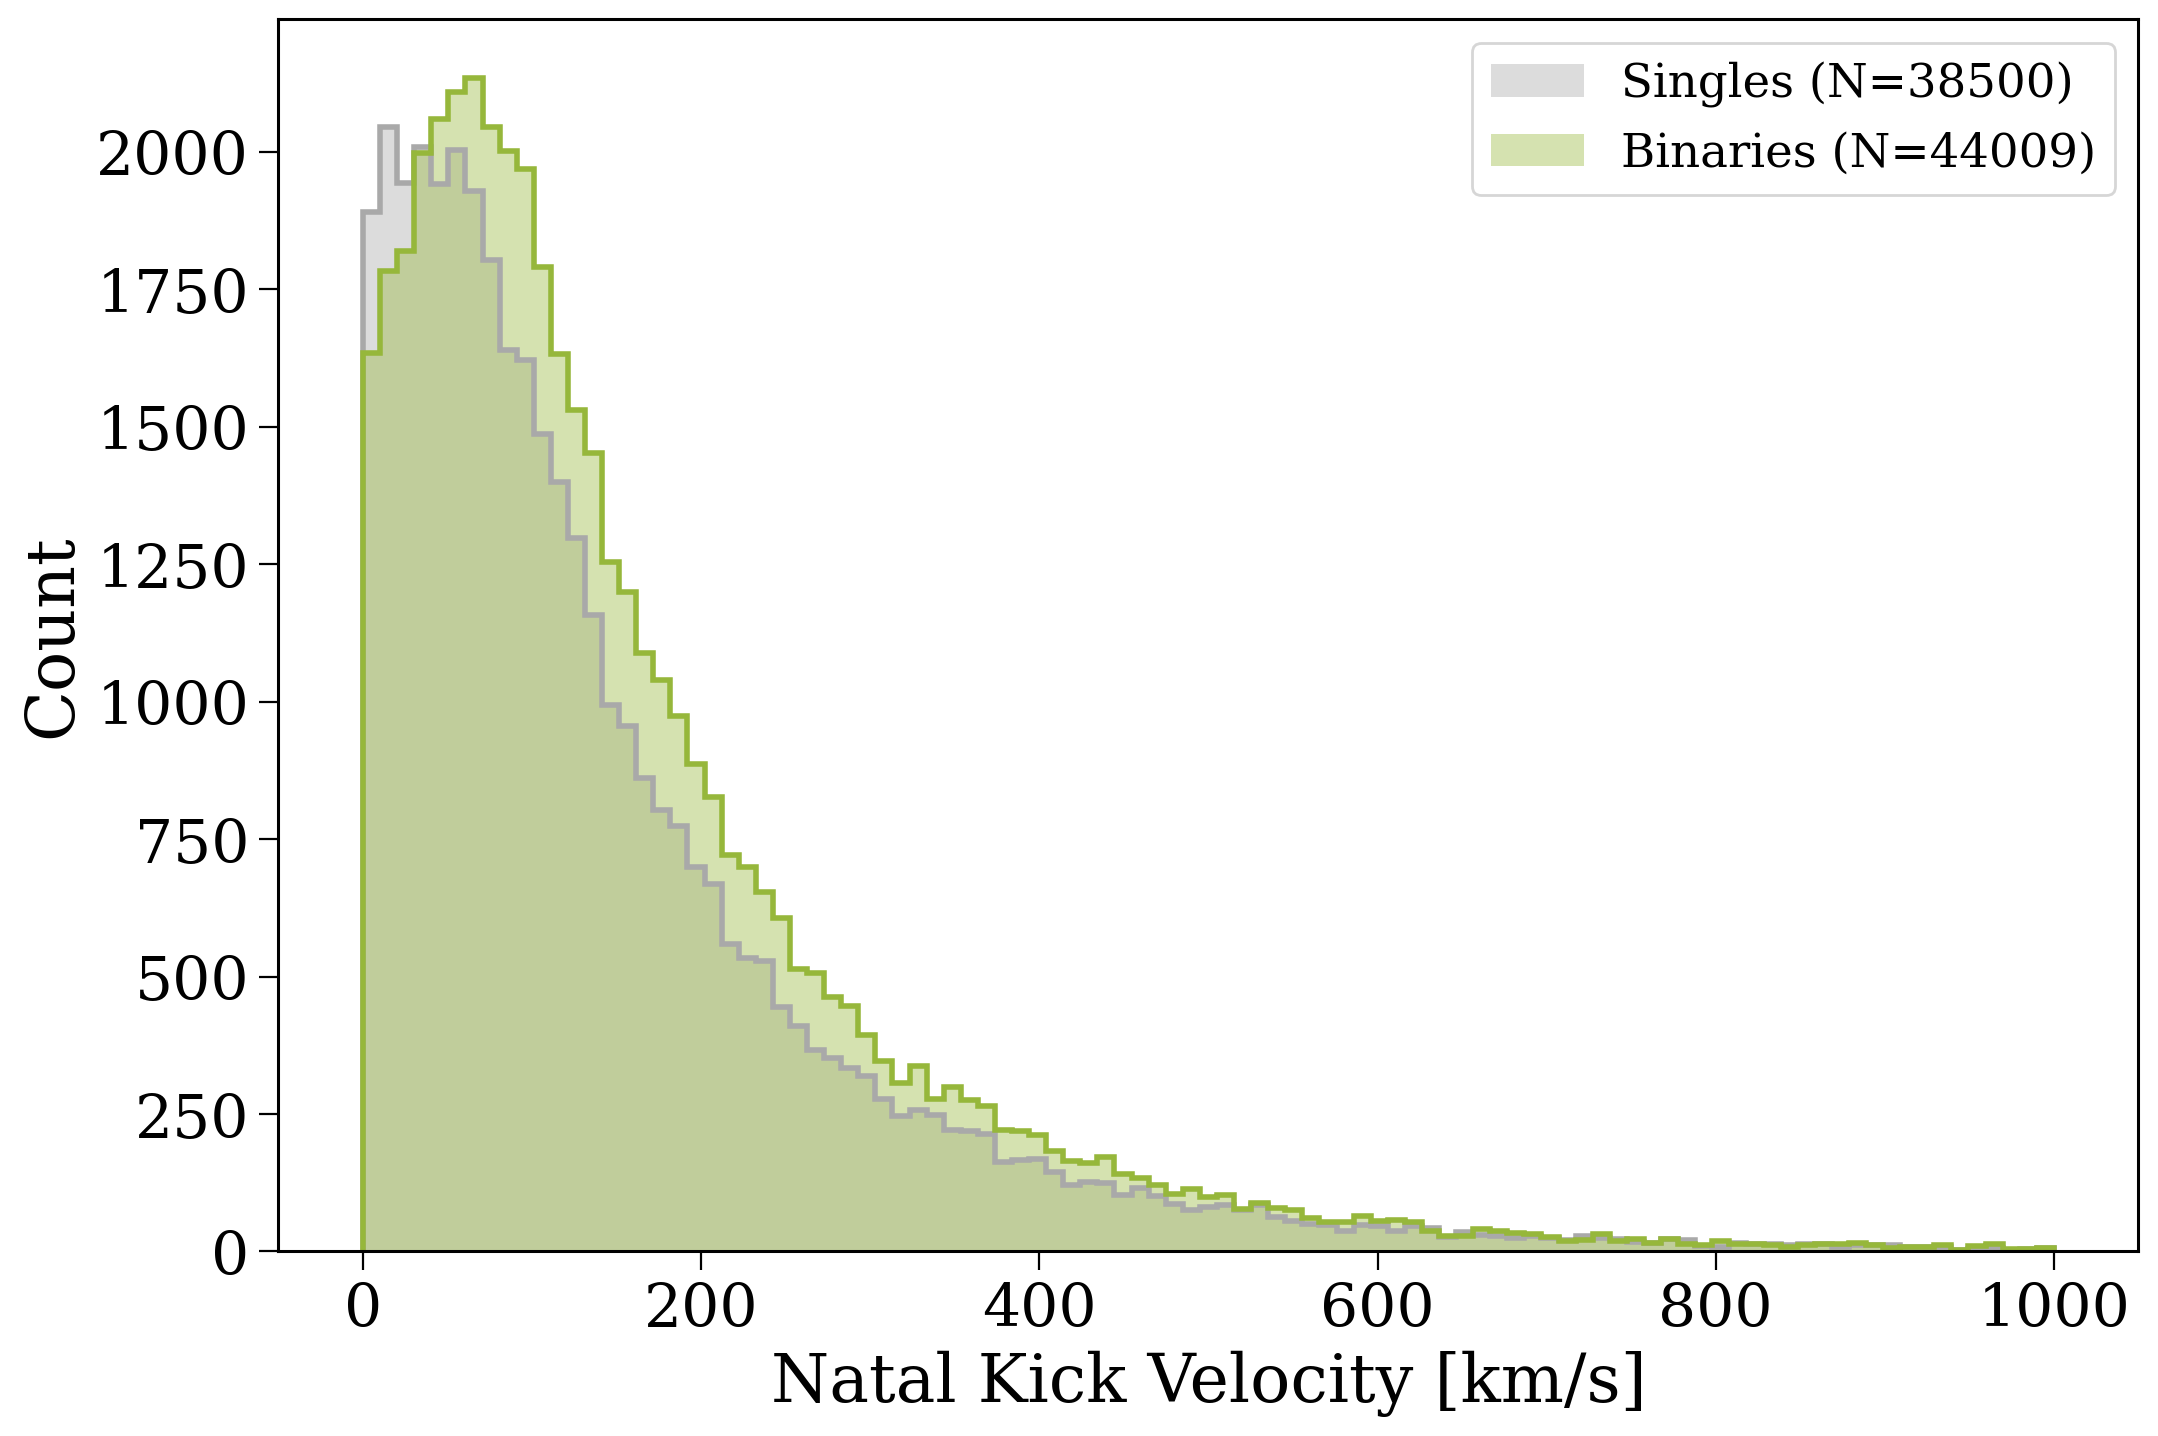

In [20]:
density = False
for co_type_label, co_type in zip(["ALL", "NS", "BH"], [[13, 14], [13], [14]]):

    fig, ax = plt.subplots()

    bins = np.linspace(0, 1000, 100)

    for pop in [singles, binaries]:
        kick_details = pop.kick_info[pop.kick_info["star"] != 0]
        kicks = kick_details["natal_kick"]
        print(len(kicks))

        kick_rows = pop.bpp[pop.bpp["evol_type"].isin([15, 16])]
        after_kick_rows = pop.bpp[pop.bpp["row_num"].isin(kick_rows["row_num"] + 1)]
        kick_co_type = np.where(kick_details["star"] == 1, after_kick_rows["kstar_1"], after_kick_rows["kstar_2"])
        
        kicks = kicks[(np.isin(kick_co_type, co_type))]
        print((kicks == 0.0).sum(), (kicks == 0.0).sum() / len(kicks))
        kicks = kicks[(kicks != 0.0)]

        ax.hist(kicks, bins=bins, density=density, histtype='step', lw=2, color=pop.colour)
        ax.hist(kicks, bins=bins, density=density, alpha=0.4, color=pop.colour,
                label=f"{pop.label} (N={len(kicks)})")
    ax.set(
        xlabel="Natal Kick Velocity [km/s]",
        ylabel="Count",
    )
    ax.legend()
    plt.show()

In [25]:
singles.bpp

tphys     mass_1     mass_2  kstar_1  kstar_2           sep  \
1          0.000000  17.727014  16.584322        1        1  2.945085e+14   
1          9.869618  17.016036  16.340217        2        1  3.029420e+14   
1          9.888730  16.984236  16.332412        4        1  3.033022e+14   
1         10.756827  11.327405  15.969034        4        2  3.705521e+14   
1         10.778422  11.161994  15.941043        4        4  3.731963e+14   
...             ...        ...        ...      ...      ...           ...   
318132    40.741515   1.344422   7.841386       13        5 -1.000000e+00   
318132    40.904585   1.344422   7.787759       13        6 -1.000000e+00   
318132    41.165328   1.344422   7.444356       13        6 -1.000000e+00   
318132    41.165328   1.344422   1.260782       13       13 -1.000000e+00   
318132  8122.830126   1.344422   1.260782       13       13 -1.000000e+00   

                porb  ecc        RRLO_1        RRLO_2  evol_type         aj_1  \
1       1.000000e+20  0.0  5.059716e-14  5.006345e-14          1     0.000000   
1       1.058091e+20  0.0  1.244785e-13  1.181592e-13          2    10.304909   
1       1.060608e+20  0.0  7.248860e-12  1.185499e-13          2    10.324021   
1       1.582315e+20  0.0  8.420427e-12  9.024735e-14          2    11.192118   
1       1.604978e+20  0.0  8.452666e-12  5.119008e-12          2    11.213713   
...              ...  ...           ...           ...        ...          ...   
318132 -1.000000e+00 -1.0  1.000000e-04  1.000000e-04          2    22.268057   
318132 -1.000000e+00 -1.0  1.000000e-04  1.000000e-04          2    22.431127   
318132 -1.000000e+00 -1.0  1.000000e-04  1.000000e-04         16    22.691871   
318132 -1.000000e+00 -1.0  1.000000e-04  1.000000e-04          2    22.691871   
318132 -1.000000e+00 -1.0  1.000000e-04  1.000000e-04         10  8104.356669   

               aj_2         tms_1         tms_2   massc_1   massc_2  \
1          0.000000  9.771440e+00  1.066343e+01  0.000000  0.000000   
1         10.005560  1.030491e+01  1.087913e+01  4.413656  0.000000   
1         10.031172  1.030491e+01  1.088619e+01  4.501926  0.000000   
1         11.226759  1.030491e+01  1.122676e+01  5.500918  4.050896   
1         11.248354  1.030491e+01  1.122676e+01  5.525769  4.131911   
...             ...           ...           ...       ...       ...   
318132    41.228018  1.000000e+10  3.677380e+01  1.344422  2.220984   
318132    41.391088  1.000000e+10  3.677380e+01  1.344422  1.425233   
318132    41.651088  1.000000e+10  3.677380e+01  1.344422  1.439946   
318132     0.000000  1.000000e+10  3.677380e+01  1.344422  1.260782   
318132  8081.664798  1.000000e+10  1.000000e+10  1.344422  1.260782   

              rad_1       rad_2    mass0_1    mass0_2         lum_1  \
1          5.732560    5.502009  17.727014  16.584322  3.146522e+04   
1         14.421496   13.438213  17.016036  16.340217  8.359786e+04   
1        840.551470   13.502993  17.016036  16.332412  9.250306e+04   
1       1090.845188   13.676482  17.016036  15.969034  1.059220e+05   
1       1099.404252  783.478319  17.016036  15.969034  1.062796e+05   
...             ...         ...        ...        ...           ...   
318132     0.000014  246.472613  12.452581   8.070936  4.917952e-05   
318132     0.000014  511.405016  12.452581   8.070936  4.846706e-05   
318132     0.000014  737.022986  12.452581   8.070936  4.735963e-05   
318132     0.000014    0.000014  12.452581   8.070936  4.735963e-05   
318132     0.000014    0.000014  12.452581   8.070936  3.712888e-10   

               lum_2         teff_1        teff_2    radc_1    radc_2  \
1       2.607547e+04   32251.726814  3.140993e+04  0.000000  0.000000   
1       5.831865e+04   25960.511210  2.457824e+04  0.562078  0.000000   
1       5.837936e+04    3487.598487  2.452559e+04  0.569192  0.000000   
1       7.075590e+04    3166.902030  2.556955e+04  0.732754  0.532195   
1       8.012280e+04    3157.209180  3.484939

In [24]:
for pop in [singles, binaries]:
    sn_types = np.concatenate((
        pop.final_bpp["SN_1"],
        pop.final_bpp["SN_2"],
    ))
    print(np.unique(sn_types[sn_types > 0], return_counts=True))

KeyError: 'SN_1'

In [33]:
binaries.final_bpp[["SN_1", "SN_2"]].value_counts()

SN_1  SN_2
1     0       126732
0     1        25097
1     1        21408
2     0         2488
0     2         2476
6     0         1700
      1          113
1     2           97
2     2           55
0     6           38
6     6           35
2     1            5
1     6            3
Name: count, dtype: int64

# Double compact objects with a NS/BH

## At present day

In [39]:
print(f"Scale everything up by a factor of ~{1e11 / binaries.mass_binaries:.0f}x\n")
for pop in [binaries]:
    # print the number of bound binaries with a CO and their kstars
    co_binaries = pop.final_bpp[
        ((pop.final_bpp["kstar_1"].isin([13, 14])) | (pop.final_bpp["kstar_2"].isin([13, 14]))) &
        (pop.final_bpp["sep"] > 0)
    ]
    print(f"Total number of DCOs: {len(co_binaries)}")
    print(co_binaries[["kstar_1", "kstar_2"]].value_counts())

Scale everything up by a factor of ~5504x

Total number of DCOs: 1296
kstar_1  kstar_2
14       14         969
         11         139
13       11          81
14       10          30
13       10          28
14       13          26
13       1           11
         13           5
         0            2
14       1            2
11       13           1
14       2            1
13       14           1
Name: count, dtype: int64


In [42]:
ns_ms = binaries.final_bpp[(binaries.final_bpp["kstar_1"] == 13) & (binaries.final_bpp["kstar_2"] < 2) & (binaries.final_bpp["sep"] > 0)]["bin_num"]

## Mergers

In [30]:
bhbh_mergers = binaries.bpp[(binaries.bpp["evol_type"] == 3) & (
    (binaries.bpp["kstar_1"] == 14) & (binaries.bpp["kstar_2"] == 14)
)]
nsns_mergers = binaries.bpp[(binaries.bpp["evol_type"] == 3) & (
    (binaries.bpp["kstar_1"] == 13) & (binaries.bpp["kstar_2"] == 13)
)]
nsbh_mergers = binaries.bpp[(binaries.bpp["evol_type"] == 3) & (
    ((binaries.bpp["kstar_1"] == 13) & (binaries.bpp["kstar_2"] == 14)) |
    ((binaries.bpp["kstar_1"] == 14) & (binaries.bpp["kstar_2"] == 13))
)]
print(f"Estimated number of mergers in a MW-mass galaxy (minimum here would be {scale_up:.0f}):")
print(f"  BH-BH mergers: {len(bhbh_mergers) * scale_up:.0f}")
print(f"  NS-NS mergers: {len(nsns_mergers) * scale_up:.0f}")
print(f"  NS-BH mergers: {len(nsbh_mergers) * scale_up:.0f}")

Estimated number of mergers in a MW-mass galaxy (minimum here would be 3302):
  BH-BH mergers: 208048
  NS-NS mergers: 0
  NS-BH mergers: 95768


# Initial conditions

## Mass

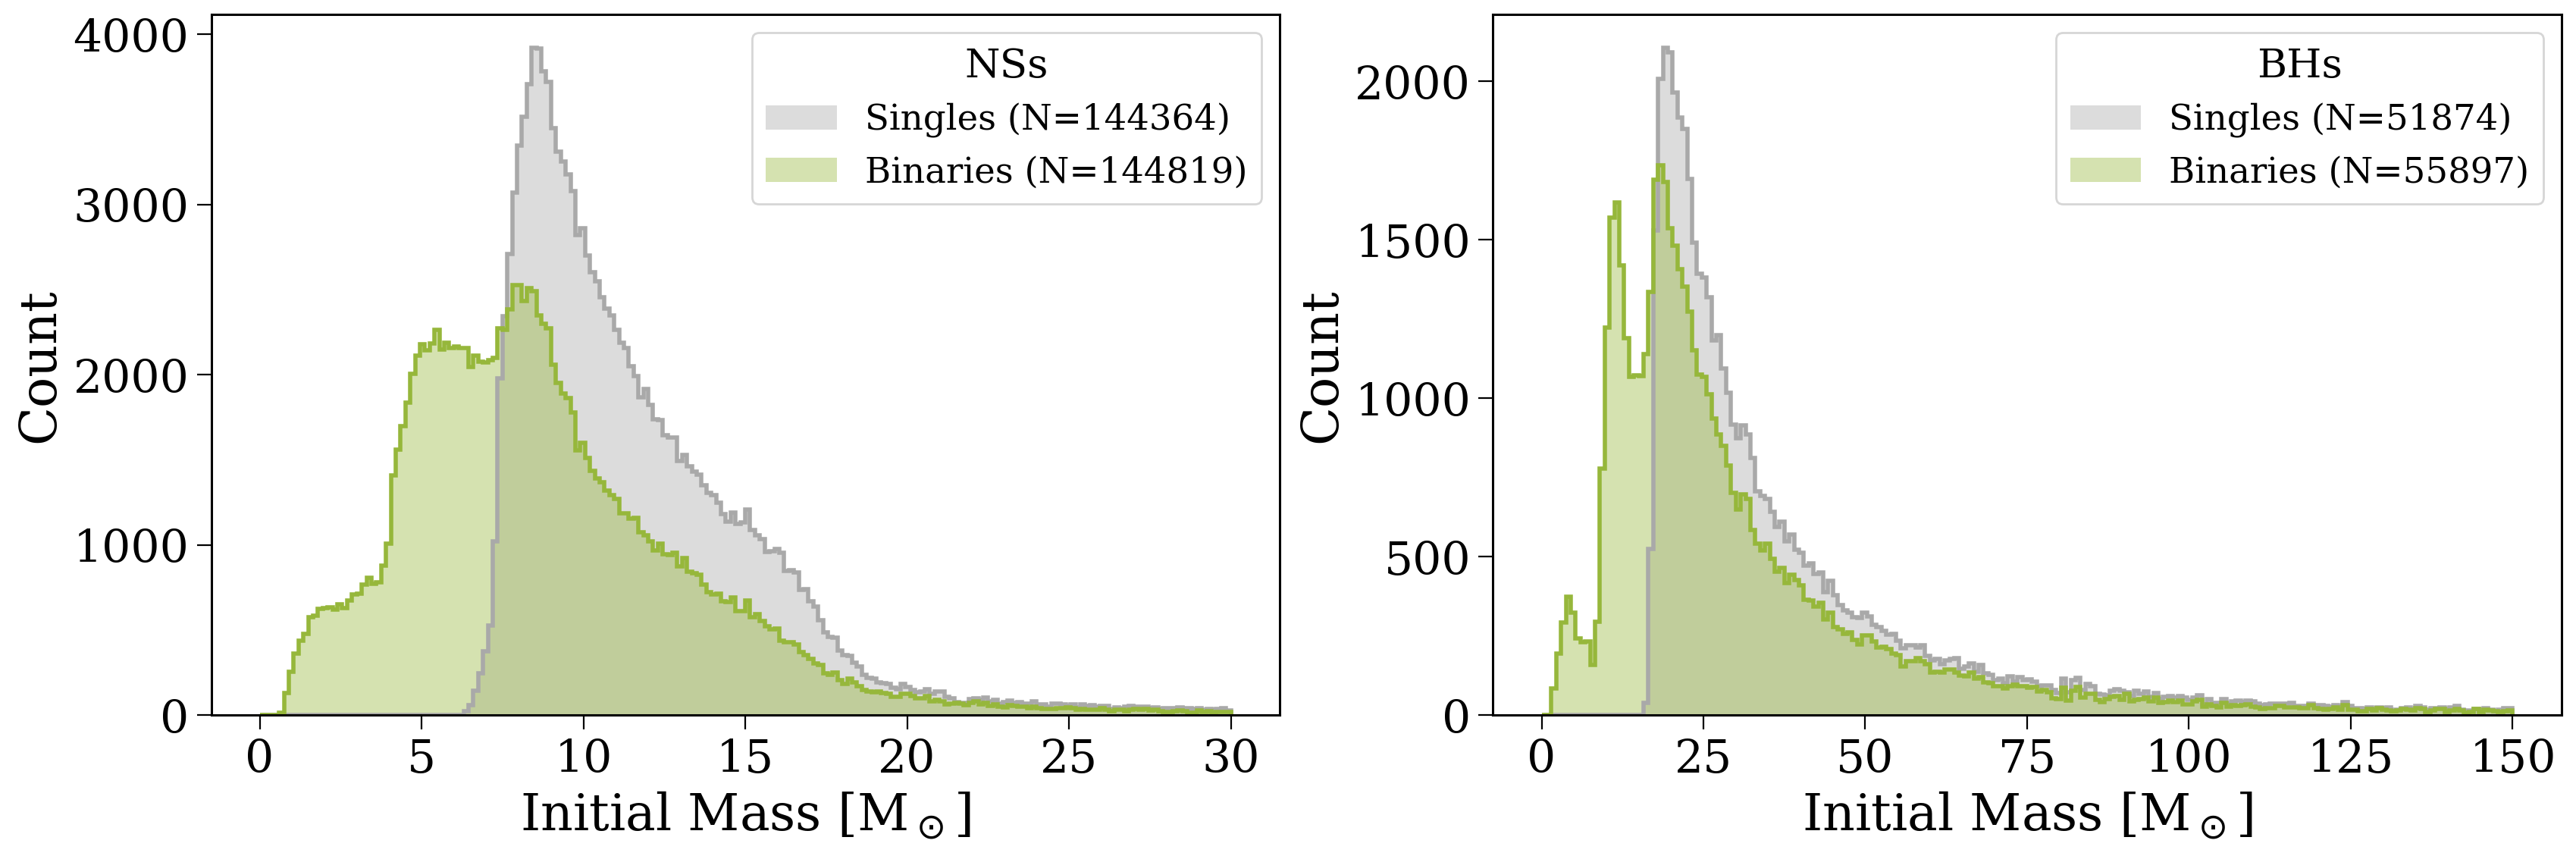

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for ax, co_type, kstar, bins in zip(axes, ['NS', 'BH'], [13, 14],
                                    [np.linspace(0, 30, 201), np.linspace(0, 150, 201)]):
    for pop in [singles, binaries]:
        init_masses = np.concatenate((
            pop.initC["mass_1"][pop.final_bpp["kstar_1"] == kstar],
            pop.initC["mass_2"][pop.final_bpp["kstar_2"] == kstar]
        ))

        ax.hist(init_masses, bins=bins, histtype='step', lw=2, color=pop.colour)
        ax.hist(init_masses, bins=bins, alpha=0.4, color=pop.colour,
                label=f"{pop.label} (N={len(init_masses)})")

    ax.set(
        xlabel=f"Initial Mass [M$_\odot$]",
        ylabel="Count"
    )
    ax.legend(title=f"{co_type}s")
plt.show()

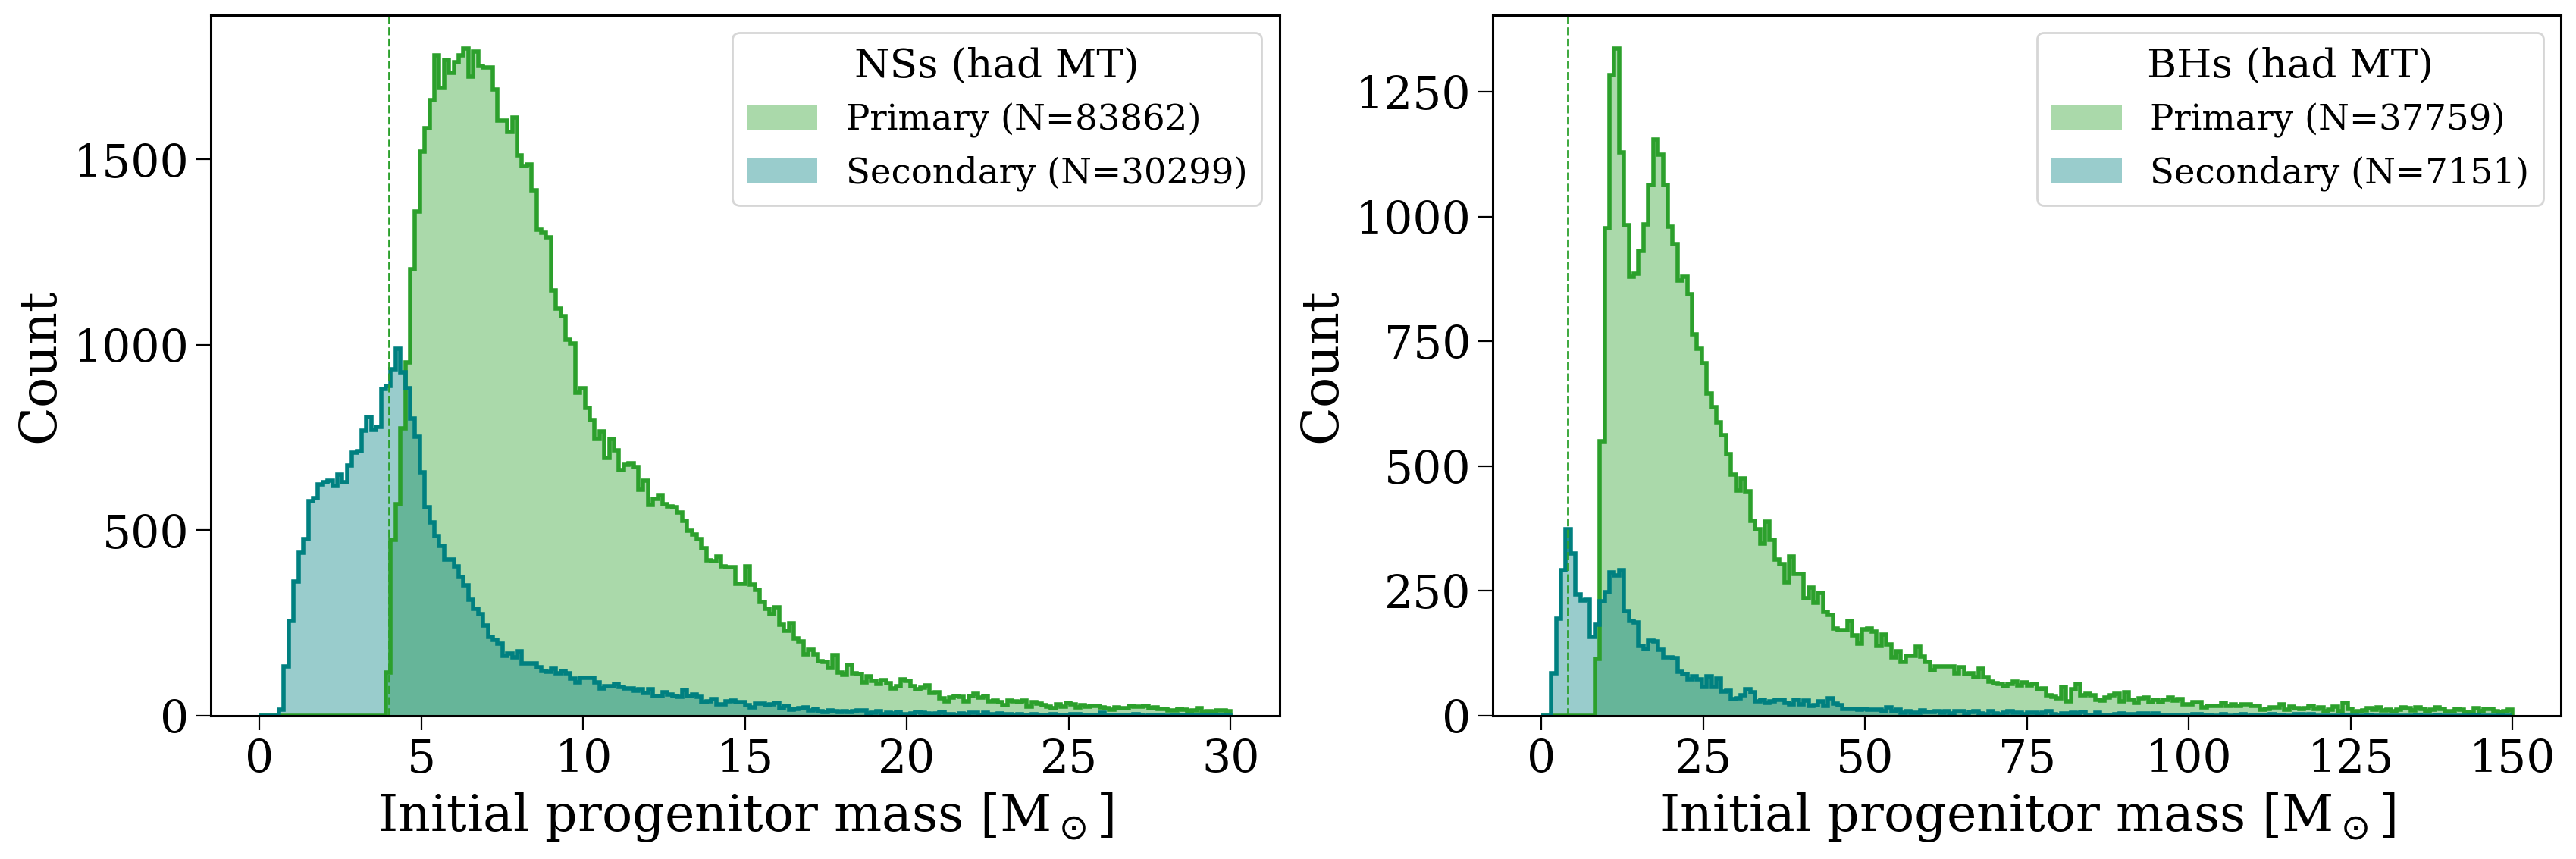

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for ax, co_type, kstar, bins in zip(axes, ['NS', 'BH'], [13, 14],
                                    [np.linspace(0, 30, 201), np.linspace(0, 150, 201)]):
    pop = binaries
    for comp, colour, label in zip(["1", "2"], ["tab:green", "teal"], ["Primary", "Secondary"]):
        experienced_mt = pop.bpp[pop.bpp["evol_type"] == 3]["bin_num"]
        experienced_ce = pop.bpp[pop.bpp["evol_type"] == 7]["bin_num"]

        init_masses = pop.initC[f"mass_{comp}"][(
            (pop.final_bpp[f"kstar_{comp}"] == kstar)
            & (pop.final_bpp["bin_num"].isin(experienced_mt))
            # & ~(pop.final_bpp["bin_num"].isin(experienced_ce))
        )]

        ax.hist(init_masses, bins=bins, histtype='step', lw=2, color=colour)
        ax.hist(init_masses, bins=bins, alpha=0.4, color=colour,
                label=f"{label} (N={len(init_masses)})")
        
    ax.axvline(4, color="tab:green", ls='--', lw=1)

    ax.set(
        xlabel=f"Initial progenitor mass [M$_\odot$]",
        ylabel="Count"
    )
    ax.legend(title=f"{co_type}s (had MT)")
plt.show()

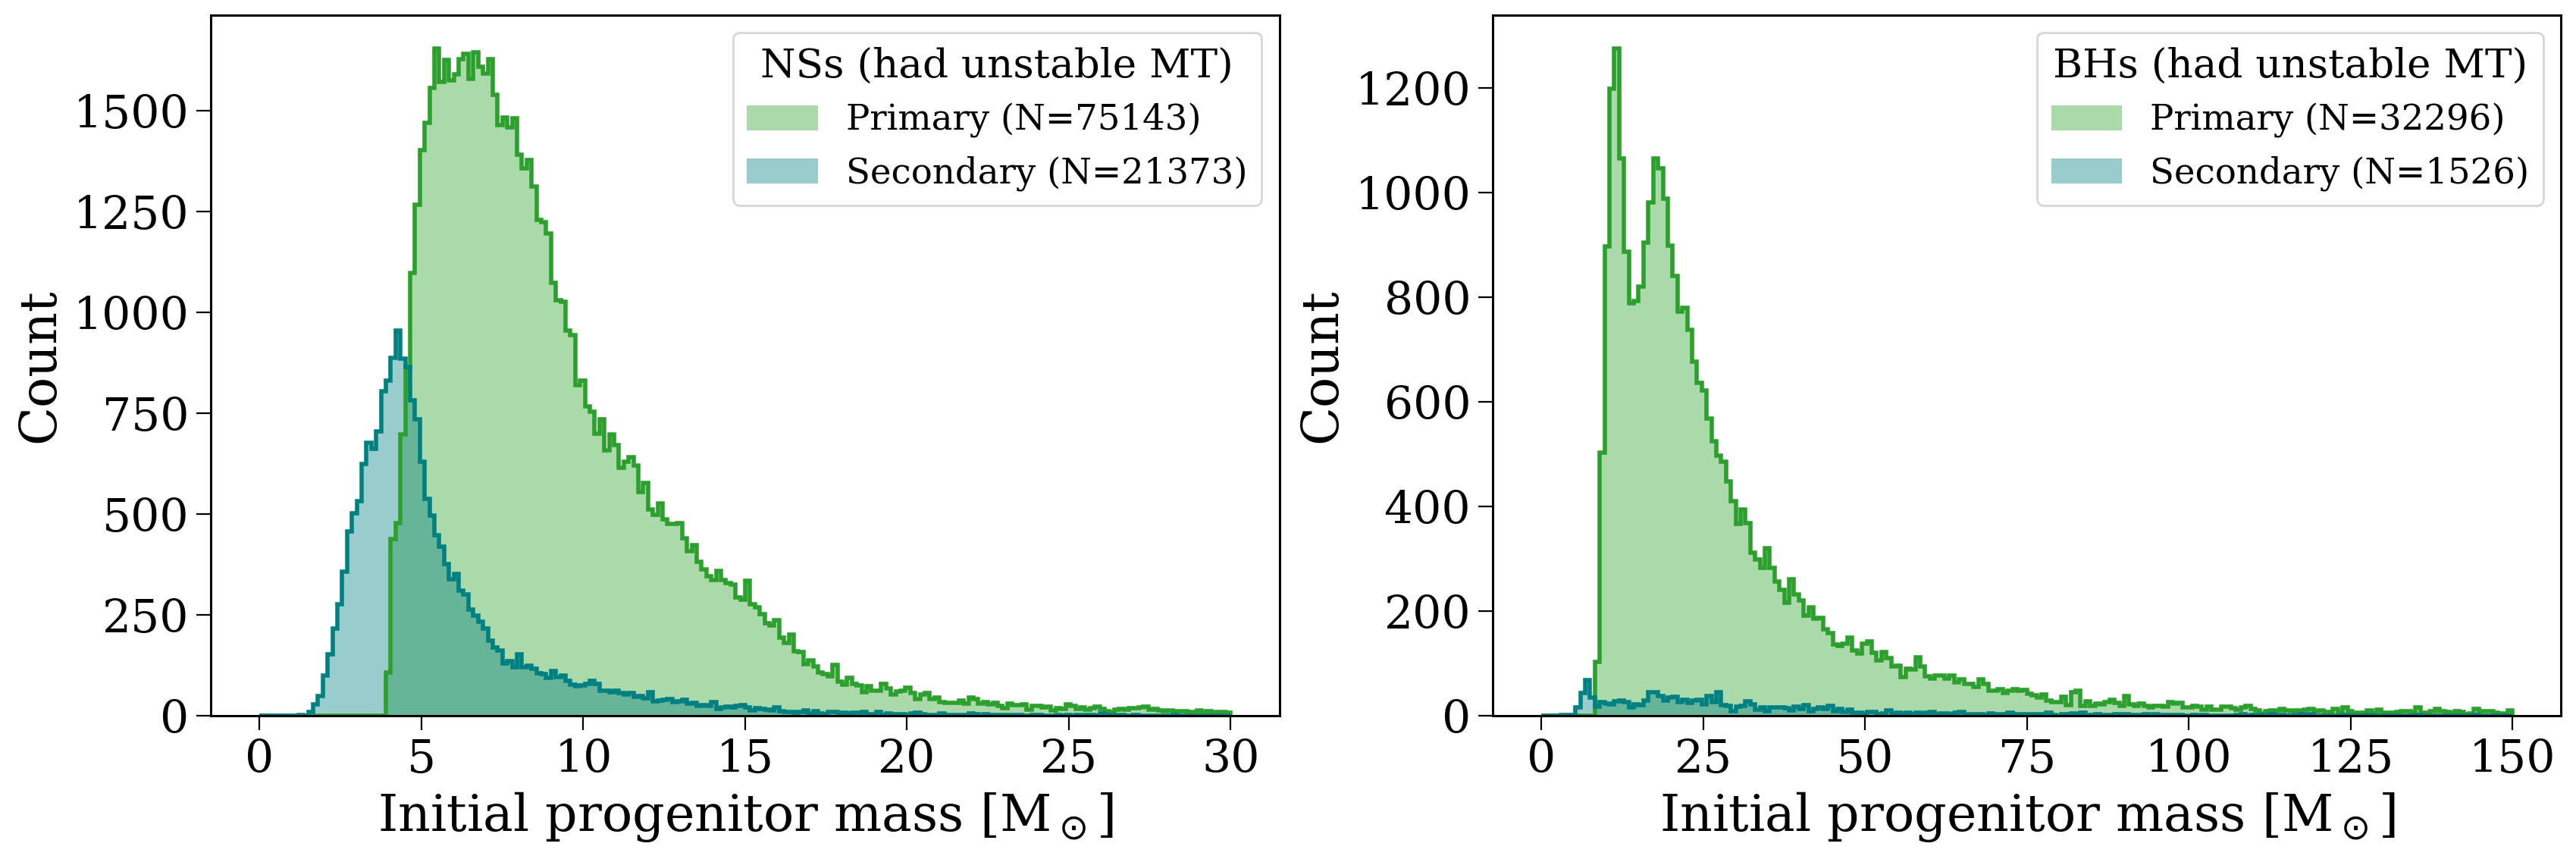

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for ax, co_type, kstar, bins in zip(axes, ['NS', 'BH'], [13, 14],
                                    [np.linspace(0, 30, 201), np.linspace(0, 150, 201)]):
    pop = binaries
    for comp, colour, label in zip(["1", "2"], ["tab:green", "teal"], ["Primary", "Secondary"]):
        experienced_mt = pop.bpp[pop.bpp["evol_type"] == 3]["bin_num"]
        experienced_ce = pop.bpp[pop.bpp["evol_type"] == 7]["bin_num"]

        init_masses = pop.initC[f"mass_{comp}"][(
            (pop.final_bpp[f"kstar_{comp}"] == kstar)
            & (pop.final_bpp["bin_num"].isin(experienced_mt))
            & (pop.final_bpp["bin_num"].isin(experienced_ce))
        )]

        ax.hist(init_masses, bins=bins, histtype='step', lw=2, color=colour)
        ax.hist(init_masses, bins=bins, alpha=0.4, color=colour,
                label=f"{label} (N={len(init_masses)})")

    ax.set(
        xlabel=f"Initial progenitor mass [M$_\odot$]",
        ylabel="Count"
    )
    ax.legend(title=f"{co_type}s (had unstable MT)")
plt.show()

## Metallicity

Worrying spike up at $Z = 0.03$

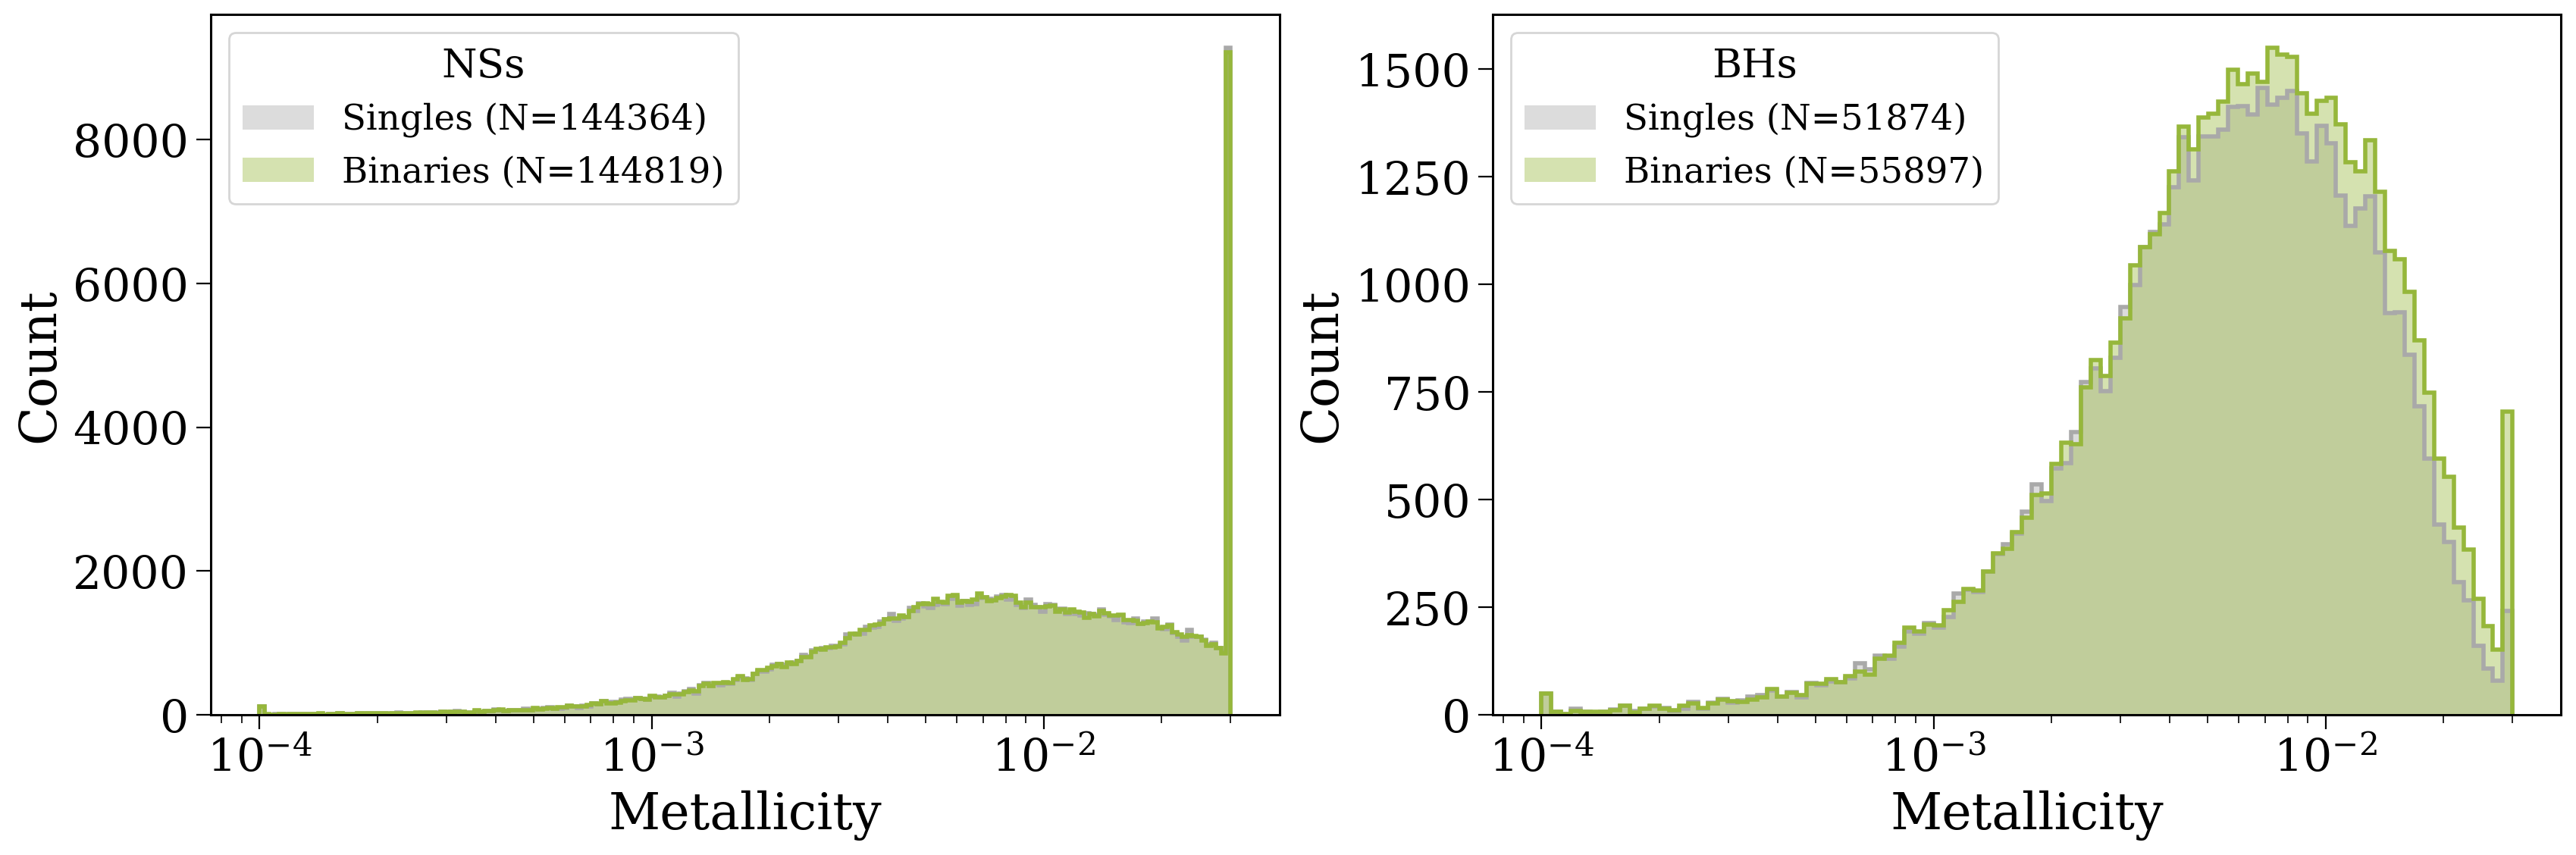

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for ax, co_type, kstar, bins in zip(axes, ['NS', 'BH'], [13, 14],
                                    [np.geomspace(1e-4, 0.03, 200), np.geomspace(1e-4, 0.03, 100)]):
    for pop in [singles, binaries]:
        init_Z = np.concatenate((
            pop.initC["metallicity"][pop.final_bpp["kstar_1"] == kstar],
            pop.initC["metallicity"][pop.final_bpp["kstar_2"] == kstar]
        ))

        ax.hist(init_Z, bins=bins, histtype='step', lw=2, color=pop.colour)
        ax.hist(init_Z, bins=bins, alpha=0.4, color=pop.colour,
                label=f"{pop.label} (N={len(init_Z)})")

    ax.set(
        xlabel=f"Metallicity",
        ylabel="Count",
        xscale='log'
    )
    ax.legend(title=f"{co_type}s")
plt.show()

## Formation time

Basically no change on galactic scales

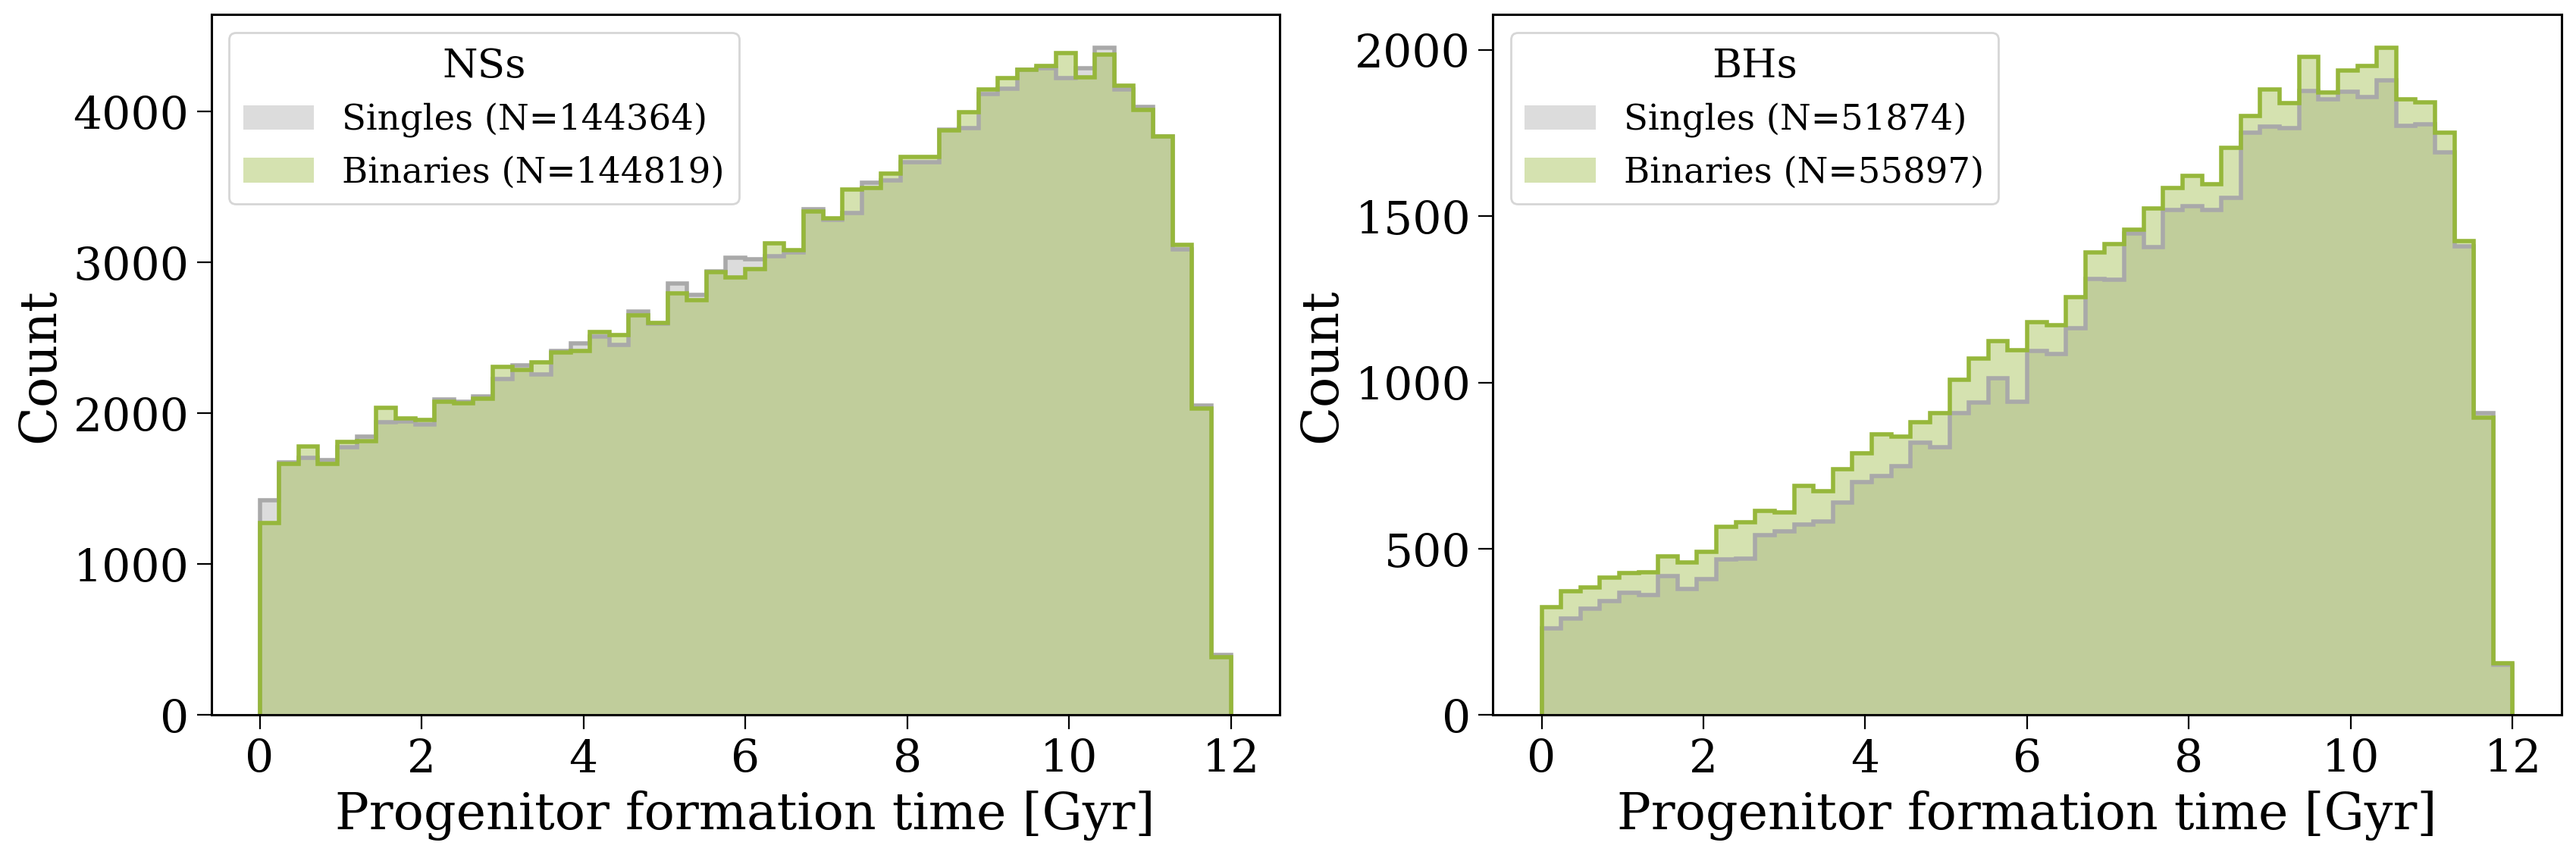

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for ax, co_type, kstar, bins in zip(axes, ['NS', 'BH'], [13, 14],
                                    [np.linspace(0, 12, 51), np.linspace(0, 12, 51)]):
    for pop in [singles, binaries]:
        tau = pd.read_hdf(pop._file, "initial_galaxy")["tau"].values
        formation_time = np.concatenate((
            tau[pop.final_bpp["kstar_1"] == kstar],
            tau[pop.final_bpp["kstar_2"] == kstar]
        ))

        ax.hist(formation_time, bins=bins, histtype='step', lw=2, color=pop.colour)
        ax.hist(formation_time, bins=bins, alpha=0.4, color=pop.colour,
                label=f"{pop.label} (N={len(formation_time)})")

    ax.set(
        xlabel=f"Progenitor formation time [Gyr]",
        ylabel="Count"
    )
    ax.legend(title=f"{co_type}s")
plt.show()

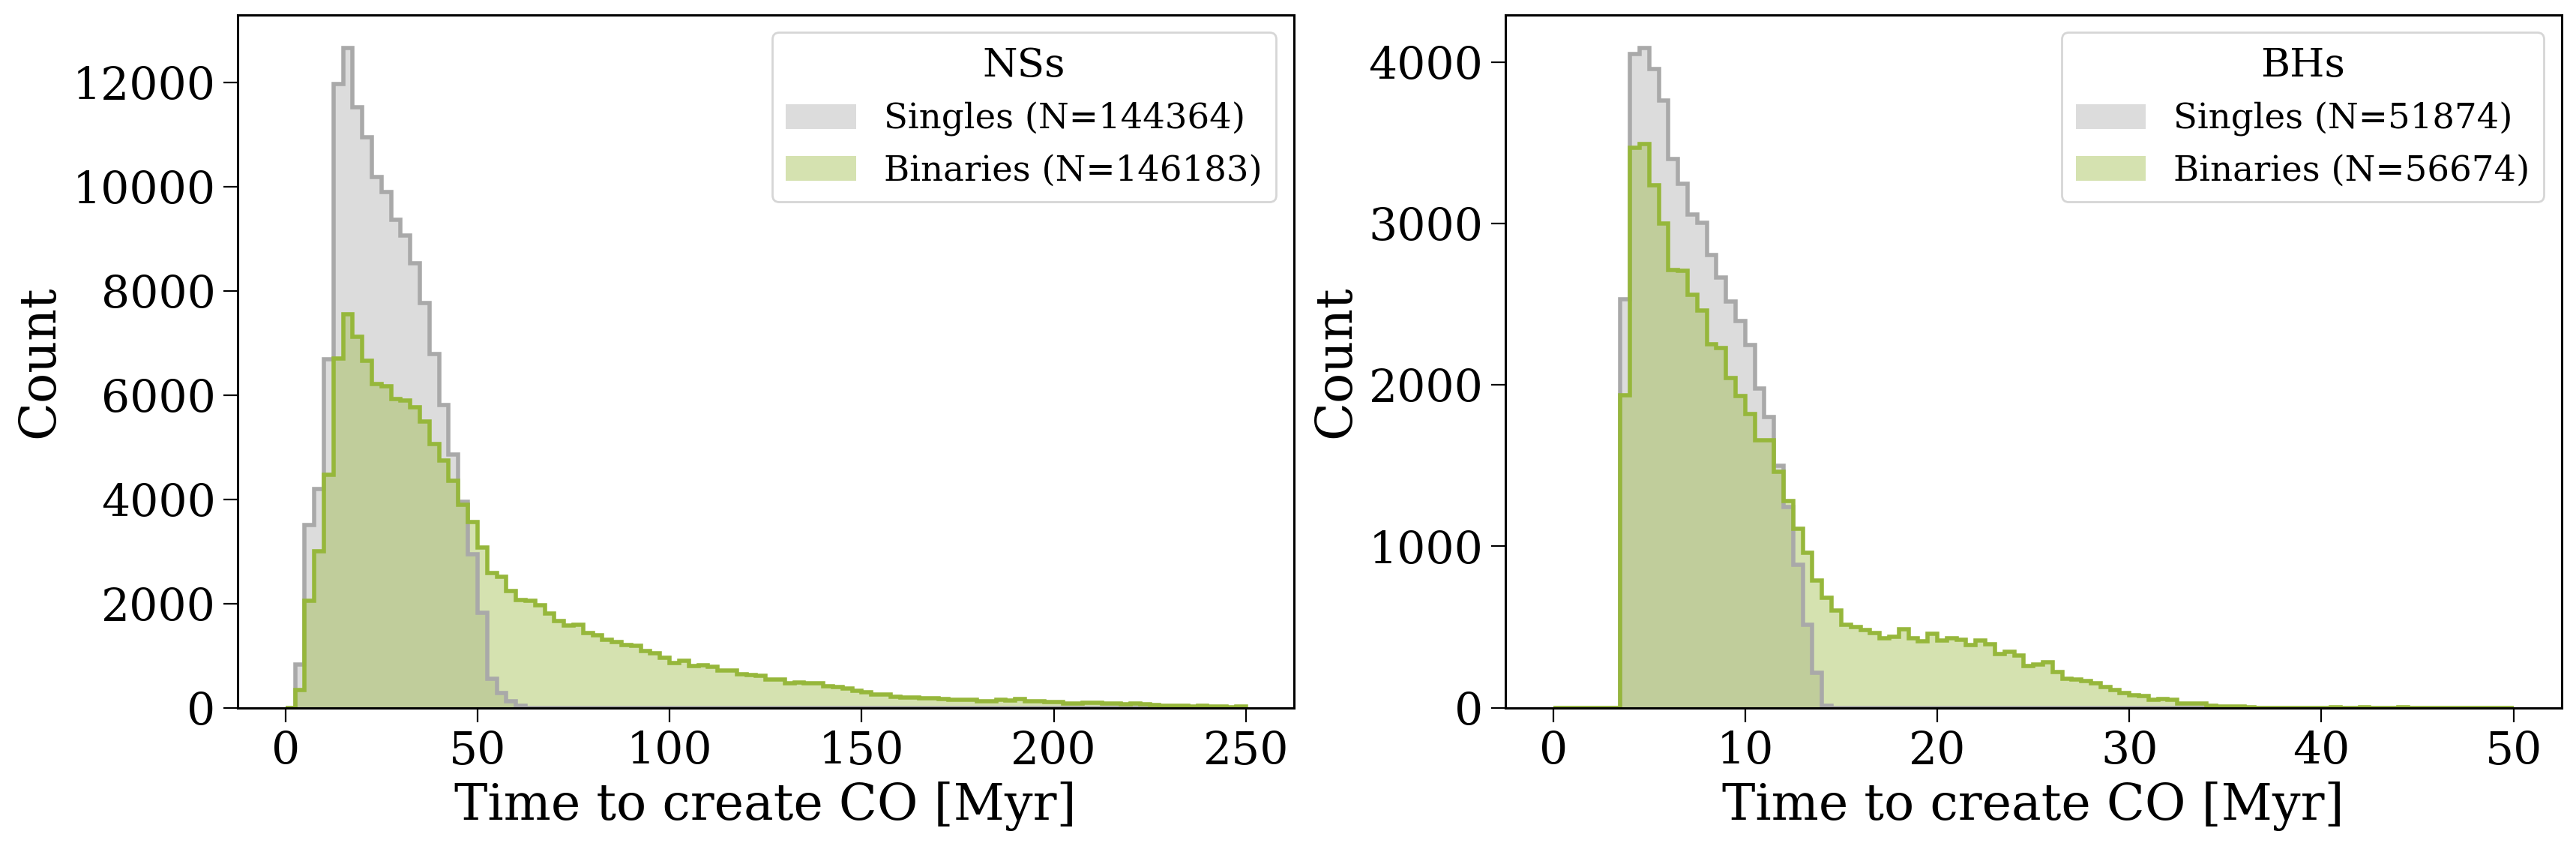

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for ax, co_type, kstar, bins in zip(axes, ['NS', 'BH'], [13, 14],
                                    [np.linspace(0, 250, 101), np.linspace(0, 50, 101)]):
    for pop in [singles, binaries]:
        co_form_time = np.concatenate((
            pop.bpp[pop.bpp["kstar_1"] == kstar].drop_duplicates(subset="bin_num", keep="first")["tphys"].values,
            pop.bpp[pop.bpp["kstar_2"] == kstar].drop_duplicates(subset="bin_num", keep="first")["tphys"].values,
        ))

        ax.hist(co_form_time, bins=bins, histtype='step', lw=2, color=pop.colour)
        ax.hist(co_form_time, bins=bins, alpha=0.4, color=pop.colour,
                label=f"{pop.label} (N={len(co_form_time)})")

    ax.set(
        xlabel=f"Time to create CO [Myr]",
        ylabel="Count"
    )
    ax.legend(title=f"{co_type}s")
plt.show()

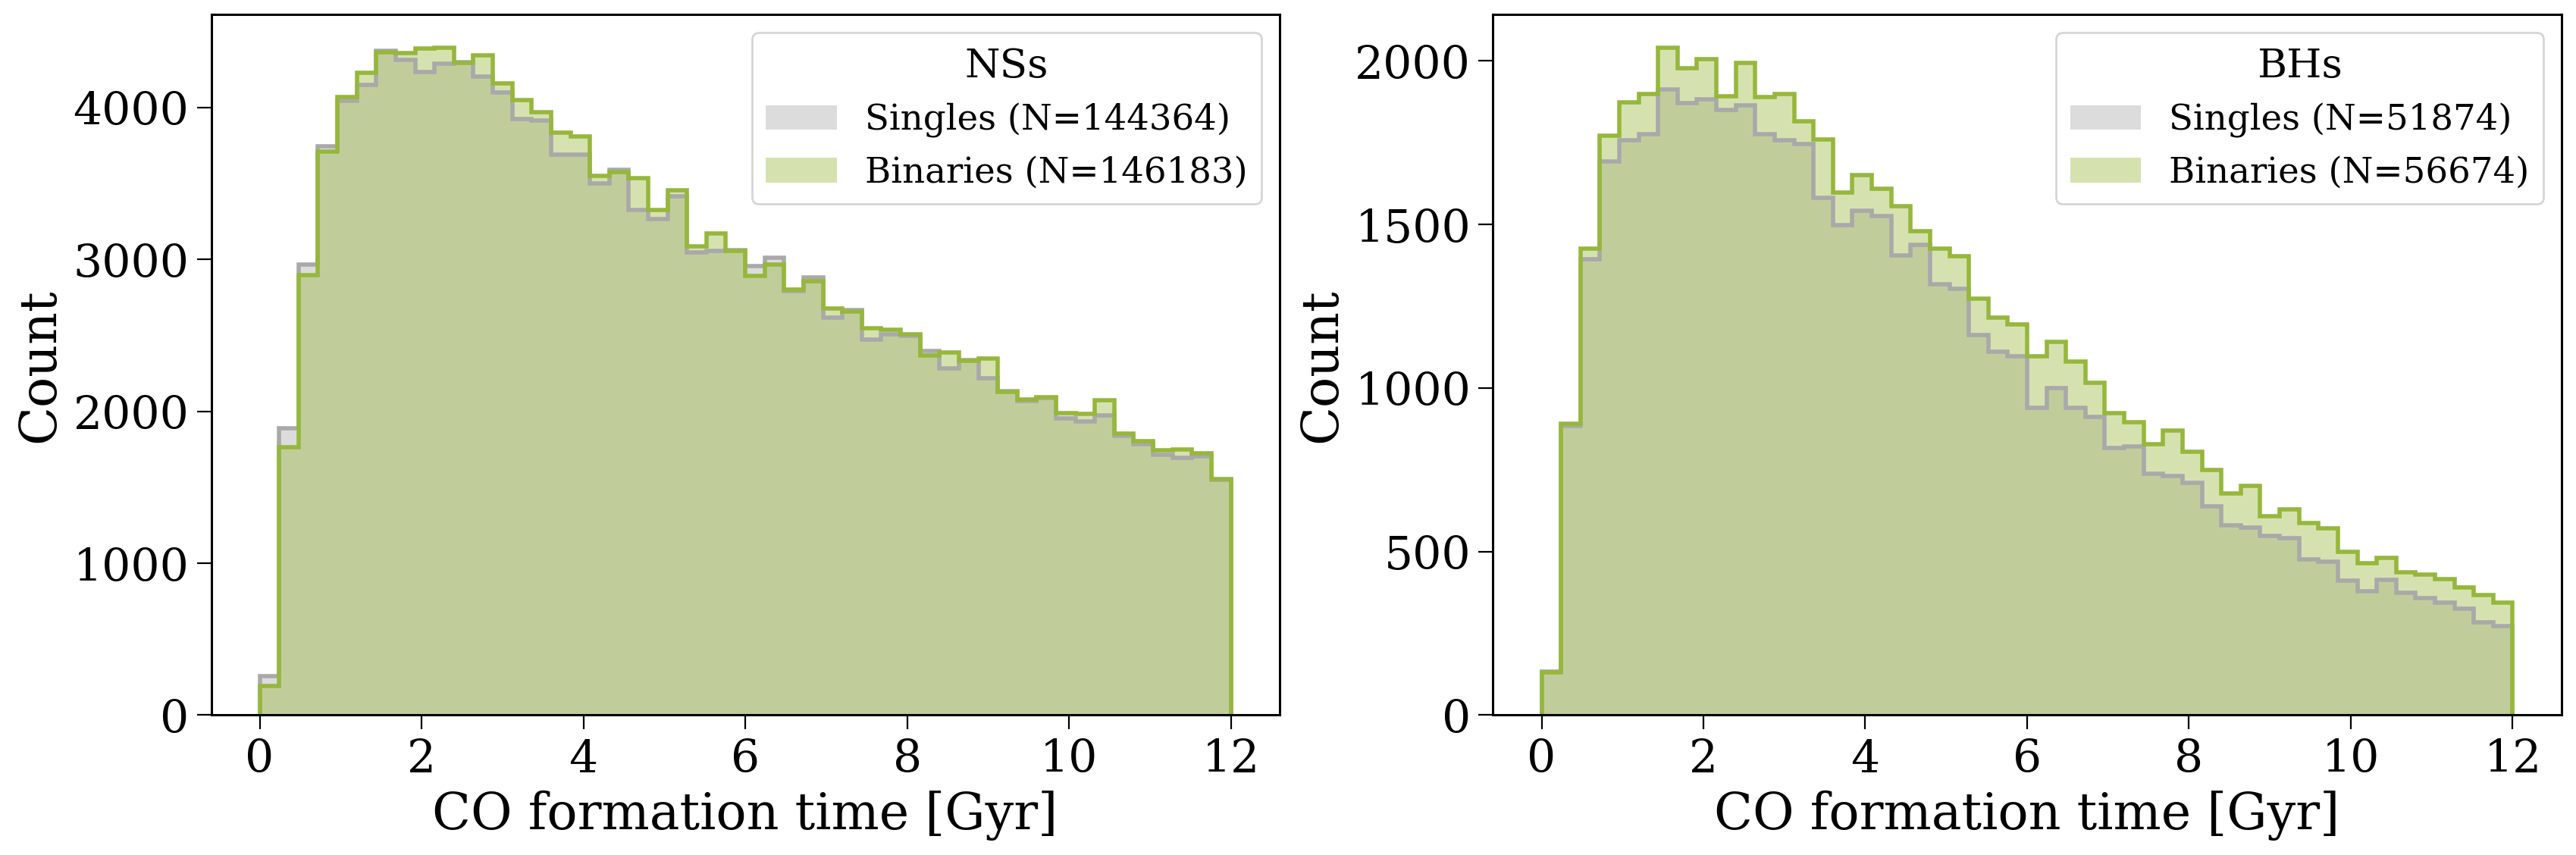

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for ax, co_type, kstar, bins in zip(axes, ['NS', 'BH'], [13, 14],
                                    [np.linspace(0, 12, 51), np.linspace(0, 12, 51)]):
    for pop in [singles, binaries]:
        initial_galaxy = pd.read_hdf(pop._file, "initial_galaxy")
        initial_galaxy.index = pop.bin_nums
        co_form_time = np.concatenate((
            pop.bpp[pop.bpp["kstar_1"] == kstar].drop_duplicates(subset="bin_num", keep="first")["tphys"].values,
            pop.bpp[pop.bpp["kstar_2"] == kstar].drop_duplicates(subset="bin_num", keep="first")["tphys"].values,
        ))
        co_form_nums = np.concatenate((
            pop.bpp[pop.bpp["kstar_1"] == kstar].drop_duplicates(subset="bin_num", keep="first")["bin_num"].values,
            pop.bpp[pop.bpp["kstar_2"] == kstar].drop_duplicates(subset="bin_num", keep="first")["bin_num"].values,
        ))
        lookback_times = initial_galaxy.loc[co_form_nums]["tau"].values
        galaxy_age = 12

        time_of_co_formation = galaxy_age - lookback_times + co_form_time / 1000

        ax.hist(time_of_co_formation, bins=bins, histtype='step', lw=2, color=pop.colour)
        ax.hist(time_of_co_formation, bins=bins, alpha=0.4, color=pop.colour,
                label=f"{pop.label} (N={len(time_of_co_formation)})")

    ax.set(
        xlabel=f"CO formation time [Gyr]",
        ylabel="Count"
    )
    ax.legend(title=f"{co_type}s")
plt.show()

## Galactic component

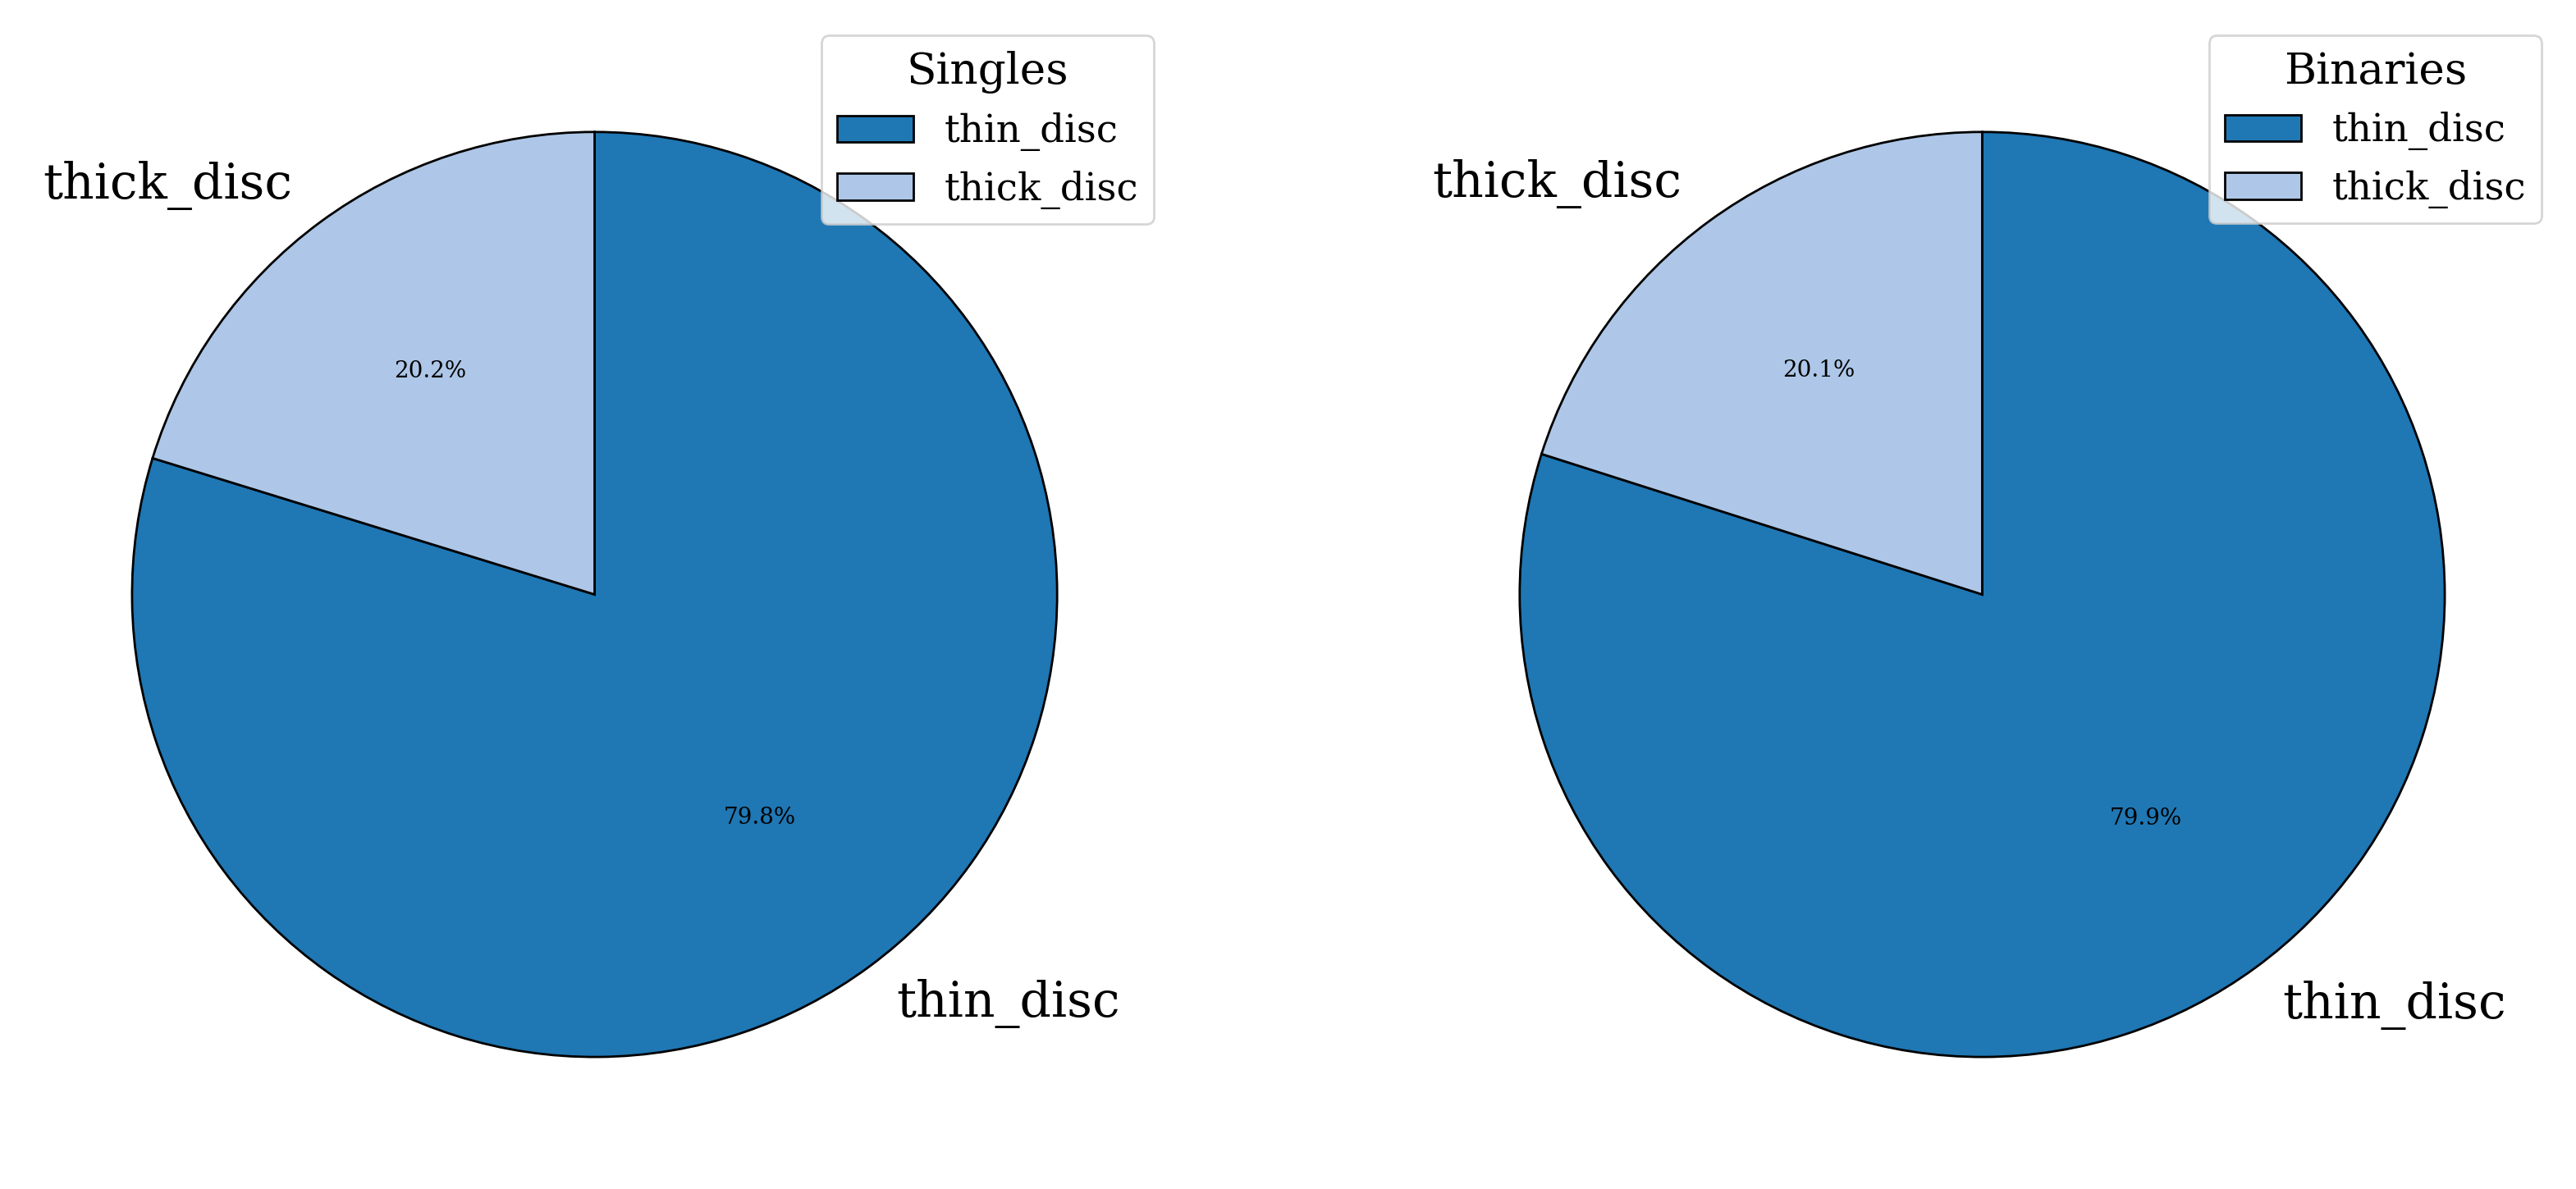

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for ax, pop in zip(axes, [singles, binaries]):
    initial_galaxy = pd.read_hdf(pop._file, "initial_galaxy")
    initial_galaxy.index = pop.bin_nums
    co_form_nums = np.concatenate((
        pop.bpp[pop.bpp["kstar_1"].isin([13, 14])].drop_duplicates(subset="bin_num", keep="first")["bin_num"].values,
        pop.bpp[pop.bpp["kstar_2"].isin([13, 14])].drop_duplicates(subset="bin_num", keep="first")["bin_num"].values,
    ))
    
    ax.pie(
        initial_galaxy.loc[co_form_nums]["which_comp"].value_counts().values,
        labels=initial_galaxy.loc[co_form_nums]["which_comp"].value_counts().index,
        autopct='%1.1f%%',
        colors=mpl.colormaps['tab20'].colors,
        startangle=90,
        counterclock=False,
        wedgeprops={'edgecolor': 'black'}
    )
    ax.legend(title=f"{pop.label}")
plt.show()